# **Capstone Project - NLP Chatbot**

### **DOMAIN:**
Industrial safety. NLP based Chatbot.

### **CONTEXT:**
The database comes from one of the biggest industry in Brazil and in the world. It is an urgent need for industries/companies around the globe to understand why employees still suffer some injuries/accidents in plants. Sometimes they also die in such environment.

### **DATA DESCRIPTION:**
This The database is basically records of accidents from 12 different plants in 03 different countries which every line in the data is an occurrence of an accident.

### **Columns description:**
* Data: timestamp or time/date information
* Countries: which country the accident occurred (anonymised)
* Local: the city where the manufacturing plant is located (anonymised)
* Industry sector: which sector the plant belongs to
* Accident level: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)
* Potential Accident Level: Depending on the Accident Level, the database also registers how severe the accident could have   been (due to other factors involved in the accident)
* Gender: if the person is male of female
* Employee or Third Party: if the injured person is an employee or a third party
* Critical Risk: some description of the risk involved in the accident
* Description: Detailed description of how the accident happened.


### **PROJECT OBJECTIVE:**
Design a ML/DL based chatbot utility which can help the professionals to highlight the safety risk as per the incident description.

 # Step 1: Import the data

Before importing data, we need to first connect google colab and import neccessary libraries

## Connect to Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
%cd /content/drive/MyDrive/Capstone Project

/content/drive/MyDrive/Capstone Project


Import necessary libraries

In [ ]:
!pip install config

In [5]:
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 26.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.


In [2]:
import warnings
warnings.filterwarnings('ignore')

#import config
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tensorflow.keras.preprocessing.text import Tokenizer # Import Tokenizer from tensorflow.keras

In [3]:
from nltk.tokenize import word_tokenize
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, LSTM,  Embedding, Dropout, Bidirectional, GlobalMaxPool1D

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate
#from keras.utils import plot_model

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from scikeras.wrappers import KerasClassifier

# Keras pre-processing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Now, we can import the data

In [ ]:
chatbot_database = pd.read_excel("/content/drive/MyDrive/Capstone Project/Data Set - industrial_safety_and_health_database_with_accidents_description.xlsx")

In [ ]:
chatbot_database.shape

(425, 11)

# Step 2: Data cleansing

### (a) Re-naming the column name:
We have 10 columns( features) and 425 rows of data. Let us Rename the column correctly, which is misspelled.

In [ ]:
chatbot_database.rename(columns={'Data':'Date', 'Countries':'Country', 'Genre':'Gender', 'Employee or Third Party':'Employee_type',
'Industry Sector':'Industry_Sector','Accident Level':'Accident_Level','Potential Accident Level':'Potential_Accident_Level',
'Critical Risk':'Critical_Risk'}, inplace=True)
chatbot_database.head(3)

Unnamed: 0       Date     Country     Local Industry_Sector Accident_Level  \
0           0 2016-01-01  Country_01  Local_01          Mining              I   
1           1 2016-01-02  Country_02  Local_02          Mining              I   
2           2 2016-01-06  Country_01  Local_03          Mining              I   

  Potential_Accident_Level Gender         Employee_type        Critical_Risk  \
0                       IV   Male           Third Party              Pressed   
1                       IV   Male              Employee  Pressurized Systems   
2                      III   Male  Third Party (Remote)         Manual Tools   

                                         Description  
0  While removing the drill rod of the Jumbo 08 f...  
1  During the activation of a sodium sulphide pum...  
2  In the sub-station MILPO located at level +170...

### (b) Checking Missing Values:

In [ ]:
datatype = pd.DataFrame(chatbot_database.dtypes)
datatype['MissingVal'] = chatbot_database.isnull().sum()
datatype['NUnique']=chatbot_database.nunique()
datatype

0  MissingVal  NUnique
Unnamed: 0                         int64           0      425
Date                      datetime64[ns]           0      287
Country                           object           0        3
Local                             object           0       12
Industry_Sector                   object           0        3
Accident_Level                    object           0        5
Potential_Accident_Level          object           0        6
Gender                            object           0        2
Employee_type                     object           0        3
Critical_Risk                     object           0       33
Description                       object           0      411

By Checking the missing value, we have 0 missing values in all 10 columns.

### (c) Removing Duplicates:

In [ ]:
chatbot_database.duplicated().sum()

0

There are no duplicate values present in the dataset

There is no use of Unnamed: 0 column in the dataset, hence, we can remove it

In [ ]:
chatbot_database.drop(columns=['Unnamed: 0'], axis=1, inplace=True)


Now, let's check if there are any duplicate comments in description column and treat them accordingly

In [ ]:
print('There are {} duplicates comments present in the description column'.format(chatbot_database.duplicated(subset=['Description'],keep=False).sum()))
chatbot_database[chatbot_database.duplicated(subset=['Description'],keep=False)].sort_values(by='Description')


There are 26 duplicates comments present in the description column


Date     Country     Local Industry_Sector Accident_Level  \
167 2016-07-07  Country_01  Local_03          Mining              I   
166 2016-07-07  Country_01  Local_03          Mining             IV   
263 2016-12-01  Country_01  Local_03          Mining              I   
262 2016-12-01  Country_01  Local_03          Mining              I   
261 2016-12-01  Country_01  Local_03          Mining              I   
303 2017-01-21  Country_02  Local_02          Mining              I   
302 2017-01-21  Country_02  Local_02          Mining              I   
412 2017-06-20  Country_01  Local_01          Mining              I   
413 2017-06-20  Country_01  Local_01          Mining              I   
77  2016-04-01  Country_01  Local_01          Mining              I   
76  2016-04-01  Country_01  Local_01          Mining              I   
397 2017-05-23  Country_01  Local_04          Mining              I   
396 2017-05-23  Country_01  Local_04          Mining              I   
131 2016-05-26  Country_03  Local_10          Others              I   
130 2016-05-26  Country_03  Local_10          Others              I   
346 2017-03-02  Country_03  Local_10          Others              I   
344 2017-03-02  Country_03  Local_10          Others              I   
345 2017-03-02  Country_03  Local_10          Others              I   
143 2016-06-08  Country_03  Local_10          Others              I   
144 2016-06-08  Country_03  Local_10          Others              I   
355 2017-03-15  Country_03  Local_10          Others              I   
354 2017-03-15  Country_03  Local_10          Others              I   
387 2017-05-06  Country_02  Local_07          Mining             IV   
388 2017-05-06  Country_02  Local_07          Mining             II   
38  2016-02-24  Country_02  Local_07          Mining              I   
37  2016-02-24  Country_02  Local_07          Mining              I   

    Potential_Accident_Level  Gender         Employee_type  \
167                       IV    Male           Third Party   
166                        V    Male           Third Party   
263                       IV    Male           Third Party   
262                       IV    Male              Employee   
261                       IV    Male              Employee   
303                        I    Male  Third Party (Remote)   
302                        I    Male  Third Party (Remote)   
412                       IV    Male              Employee   
413                       IV    Male           Third Party   
77                         V    Male  Third Party (Remote)   
76                         V    Male  Third Party (Remote)   
397                       IV    Male           Third Party   
396                       IV    Male           Third Party   
131                        I    Male              Employee   
130                        I    Male           Third Party   
346                        I    Male           Third Party   
344                        I    Male           Third Party   
345                        I    Male           Third Party   
143                        I    Male           Third Party   
144                        I    Male           Third Party   
355                        I    Male           Third Party   
354                        I    Male           Third Party   
387                        V    Male              Employee   
388                        V    Male              Employee   
38                         V  Female           Third Party   
37                         V    Male              Employee   

               Critical_Risk  \
167                   Others   
166                   Others   
263                   Others   
262                   Others   
261                   Others   
303                   Others   
302                   Others   
412                   Others   
413                   Others   
77                    Others   
76                    Others   
397  Projection of fragments   
3

We can see from the above tables, the description content is same but some columns value are different which indicates that those can be incorrect values. The dates for those incidents are same. Hence, we can drop those duplicate columns

In [ ]:

chatbot_database.drop_duplicates(subset=['Description'], keep='first', inplace=True)
print('After removing duplicates the shape of the dataset is:', chatbot_database.shape)

After removing duplicates the shape of the dataset is: (411, 10)


### (d) Checking Outliers:

Let's check the outliers by extracting the unique values for each columns

In [ ]:
for x in chatbot_database.columns:
    if x != 'Description' and x != 'Date':
        print('--'*30); print(f'Unique values of "{x}" column'); print('--'*30)
        print(chatbot_database[x].unique())
        print("\n")

------------------------------------------------------------
Unique values of "Country" column
------------------------------------------------------------
['Country_01' 'Country_02' 'Country_03']


------------------------------------------------------------
Unique values of "Local" column
------------------------------------------------------------
['Local_01' 'Local_02' 'Local_03' 'Local_04' 'Local_05' 'Local_06'
 'Local_07' 'Local_08' 'Local_10' 'Local_09' 'Local_11' 'Local_12']


------------------------------------------------------------
Unique values of "Industry_Sector" column
------------------------------------------------------------
['Mining' 'Metals' 'Others']


------------------------------------------------------------
Unique values of "Accident_Level" column
------------------------------------------------------------
['I' 'IV' 'III' 'II' 'V']


------------------------------------------------------------
Unique values of "Potential_Accident_Level" column
------------

After checking the unique values for entire columns, we can now say that there are no outliers in the dataset.

There are 3 countries, 12 Locals, 3 Industry sectors, 5 accident levels, 6 potential accident levels, 3 Employee types and 33 Critical Risks present in the dataset

In the accident level, we have 5 levels however in the potential accident level, we have 6 levels. Let's see the count of each levels in the potential accident column

In [ ]:
potential_accident_level_counts = chatbot_database['Potential_Accident_Level'].value_counts()
print(potential_accident_level_counts)


Potential_Accident_Level
IV     138
III    106
II      95
I       43
V       28
VI       1
Name: count, dtype: int64


As we can see that there is only 1 level VI data present in the potential accident level, so we can replace the same with level V

In [ ]:
chatbot_database['Potential_Accident_Level'] = chatbot_database['Potential_Accident_Level'].replace('VI', 'V')

In [ ]:
potential_accident_level_counts = chatbot_database['Potential_Accident_Level'].value_counts()
print(potential_accident_level_counts)

Potential_Accident_Level
IV     138
III    106
II      95
I       43
V       29
Name: count, dtype: int64


## (e) Streamline date column to get some insights

Let us first check the duration of the database

In [ ]:
print(chatbot_database.Date.min())
print(chatbot_database.Date.max())

2016-01-01 00:00:00
2017-07-09 00:00:00


This is the 19 months data which has data from january 2016 till July 2017

Now, let's split the date value into year, month, day, name of the day and week of the year.

In [ ]:
chatbot_database['Date'] = pd.to_datetime(chatbot_database['Date'])
chatbot_database['Year'] = chatbot_database['Date'].apply(lambda x : x.year)
chatbot_database['Month'] = chatbot_database['Date'].apply(lambda x : x.month)
chatbot_database['Day'] = chatbot_database['Date'].apply(lambda x : x.day)
chatbot_database['Weekday'] = chatbot_database['Date'].apply(lambda x : x.day_name())
chatbot_database['WeekofYear'] = chatbot_database['Date'].apply(lambda x : x.weekofyear)
chatbot_database.head(3)

Date     Country     Local Industry_Sector Accident_Level  \
0 2016-01-01  Country_01  Local_01          Mining              I   
1 2016-01-02  Country_02  Local_02          Mining              I   
2 2016-01-06  Country_01  Local_03          Mining              I   

  Potential_Accident_Level Gender         Employee_type        Critical_Risk  \
0                       IV   Male           Third Party              Pressed   
1                       IV   Male              Employee  Pressurized Systems   
2                      III   Male  Third Party (Remote)         Manual Tools   

                                         Description  Year  Month  Day  \
0  While removing the drill rod of the Jumbo 08 f...  2016      1    1   
1  During the activation of a sodium sulphide pum...  2016      1    2   
2  In the sub-station MILPO located at level +170...  2016      1    6   

     Weekday  WeekofYear  
0     Friday          53  
1   Saturday          53  
2  Wednesday           1

We can now create a new column where seasons are mentioned. This will help us to analyize the season wise accident incident.

In the problem statement, it was mentioned this dataset was collected in Brazil and according to web page, Brazil has four climents :-

*   Spring : September to November
*   Summer : December to March
*   Autumn : April to June
*   Winter : July to August

We can create seasonal variable based on month variable.


In [ ]:
def month2seasons(x):
    if x in [9, 10, 11]:
        season = 'Spring'
    elif x in [12, 1, 2,3]:
        season = 'Summer'
    elif x in [4, 5,6]:
        season = 'Autumn'
    elif x in [7, 8]:
        season = 'Winter'
    return season

In [ ]:
chatbot_database['Season'] = chatbot_database['Month'].apply(month2seasons)
chatbot_database.head(3)

Date     Country     Local Industry_Sector Accident_Level  \
0 2016-01-01  Country_01  Local_01          Mining              I   
1 2016-01-02  Country_02  Local_02          Mining              I   
2 2016-01-06  Country_01  Local_03          Mining              I   

  Potential_Accident_Level Gender         Employee_type        Critical_Risk  \
0                       IV   Male           Third Party              Pressed   
1                       IV   Male              Employee  Pressurized Systems   
2                      III   Male  Third Party (Remote)         Manual Tools   

                                         Description  Year  Month  Day  \
0  While removing the drill rod of the Jumbo 08 f...  2016      1    1   
1  During the activation of a sodium sulphide pum...  2016      1    2   
2  In the sub-station MILPO located at level +170...  2016      1    6   

     Weekday  WeekofYear  Season  
0     Friday          53  Summer  
1   Saturday          53  Summer  
2  Wednesday           1  Summer

Let us check the time date and the spread of data across time.

In [ ]:
year_data = pd.DataFrame(chatbot_database.dtypes)
year_data['NUnique']=chatbot_database.nunique()
year_data.iloc[10:16]

0  NUnique
Year         int64        2
Month        int64       12
Day          int64       31
Weekday     object        7
WeekofYear   int64       53
Season      object        4

In [ ]:
datelist = ['Year','Month','Day','Weekday','Season']
for x in datelist:
    print('--'*30); print(f'Unique values of "{x}" column'); print('--'*30)
    print(chatbot_database[x].unique())
    print("\n")

------------------------------------------------------------
Unique values of "Year" column
------------------------------------------------------------
[2016 2017]


------------------------------------------------------------
Unique values of "Month" column
------------------------------------------------------------
[ 1  2  3  4  5  6  7  8  9 10 11 12]


------------------------------------------------------------
Unique values of "Day" column
------------------------------------------------------------
[ 1  2  6  8 10 12 16 17 19 26 28 30  4  7 21 25  9 15 14 13 20 18 22 24
 29 27  3  5 11 31 23]


------------------------------------------------------------
Unique values of "Weekday" column
------------------------------------------------------------
['Friday' 'Saturday' 'Wednesday' 'Sunday' 'Tuesday' 'Thursday' 'Monday']


------------------------------------------------------------
Unique values of "Season" column
------------------------------------------------------------
['S

* We have accidents happened between 2016 to 2017 as per year column.
* The accidents is spread across all months, days and weekday.

# **Step 3: Data preprocessing (NLP Preprocessing techniques)**

Install pyspellchecker library for spell check.

In [ ]:
!pip install contractions
!pip install pyspellchecker
verbose= False

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 63.0 MB/s eta 0:00:00


## (a) Text Lowercase

In [ ]:
def text_lowercase(text):
    return text.lower()

In [ ]:
chatbot_database['Description_preprocess'] = chatbot_database['Description'].apply(lambda x: text_lowercase(x))

In [ ]:
chatbot_database.head()

Date     Country     Local Industry_Sector Accident_Level  \
0 2016-01-01  Country_01  Local_01          Mining              I   
1 2016-01-02  Country_02  Local_02          Mining              I   
2 2016-01-06  Country_01  Local_03          Mining              I   
3 2016-01-08  Country_01  Local_04          Mining              I   
4 2016-01-10  Country_01  Local_04          Mining             IV   

  Potential_Accident_Level Gender         Employee_type        Critical_Risk  \
0                       IV   Male           Third Party              Pressed   
1                       IV   Male              Employee  Pressurized Systems   
2                      III   Male  Third Party (Remote)         Manual Tools   
3                        I   Male           Third Party               Others   
4                       IV   Male           Third Party               Others   

                                         Description  Year  Month  Day  \
0  While removing the drill rod of the Jumbo 08 f...  2016      1    1   
1  During the activation of a sodium sulphide pum...  2016      1    2   
2  In the sub-station MILPO located at level +170...  2016      1    6   
3  Being 9:45 am. approximately in the Nv. 1880 C...  2016      1    8   
4  Approximately at 11:45 a.m. in circumstances t...  2016      1   10   

     Weekday  WeekofYear  Season  \
0     Friday          53  Summer   
1   Saturday          53  Summer   
2  Wednesday           1  Summer   
3     Friday           1  Summer   
4     Sunday           1  Summer   

                              Description_preprocess  
0  while removing the drill rod of the jumbo 08 f...  
1  during the activation of a sodium sulphide pum...  
2  in the sub-station milpo located at level +170...  
3  being 9:45 am. approximately in the nv. 1880 c...  
4  approximately at 11:45 a.m. in circumstances t...

## (b) Text Punctuation

In [ ]:
import re

def cleanPunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[0-9]',r'',cleaned)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

In [ ]:
chatbot_database['Description_preprocess'] = chatbot_database['Description_preprocess'].str.replace("[0-9]", " ")

## (c) Remove Punctuation

In [ ]:
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [ ]:
chatbot_database['Description_preprocess'] = chatbot_database['Description_preprocess'].apply(lambda x: remove_punctuation(x))

In [ ]:
chatbot_database.head()

Date     Country     Local Industry_Sector Accident_Level  \
0 2016-01-01  Country_01  Local_01          Mining              I   
1 2016-01-02  Country_02  Local_02          Mining              I   
2 2016-01-06  Country_01  Local_03          Mining              I   
3 2016-01-08  Country_01  Local_04          Mining              I   
4 2016-01-10  Country_01  Local_04          Mining             IV   

  Potential_Accident_Level Gender         Employee_type        Critical_Risk  \
0                       IV   Male           Third Party              Pressed   
1                       IV   Male              Employee  Pressurized Systems   
2                      III   Male  Third Party (Remote)         Manual Tools   
3                        I   Male           Third Party               Others   
4                       IV   Male           Third Party               Others   

                                         Description  Year  Month  Day  \
0  While removing the drill rod of the Jumbo 08 f...  2016      1    1   
1  During the activation of a sodium sulphide pum...  2016      1    2   
2  In the sub-station MILPO located at level +170...  2016      1    6   
3  Being 9:45 am. approximately in the Nv. 1880 C...  2016      1    8   
4  Approximately at 11:45 a.m. in circumstances t...  2016      1   10   

     Weekday  WeekofYear  Season  \
0     Friday          53  Summer   
1   Saturday          53  Summer   
2  Wednesday           1  Summer   
3     Friday           1  Summer   
4     Sunday           1  Summer   

                              Description_preprocess  
0  while removing the drill rod of the jumbo 08 f...  
1  during the activation of a sodium sulphide pum...  
2  in the substation milpo located at level 170 w...  
3  being 945 am approximately in the nv 1880 cx69...  
4  approximately at 1145 am in circumstances that...

## (d) Remove Special Characters

In [ ]:
def remove_spc_char(text):
    text.str.replace('[^\w\s]','')
# \w: Returns a match where the string contains any word characters (characters from a to Z, digits from 0-9, and the underscore _ character)
# \s: Returns a match where the string contains a white space character.
# [^]: Returns a match for any character EXCEPT what is written after it.

# data['result'] = data['result'].map(lambda x: x.lstrip('+-').rstrip('aAbBcC'))

In [ ]:
chatbot_database['Description_preprocess'] = chatbot_database['Description_preprocess'].str.replace('[^\w\s]','')

## (e) Remove whitespaces

In [ ]:
# remove whitespace from text
def remove_whitespace(text):
    return  " ".join(text.split())

In [ ]:
chatbot_database['Description_preprocess'] = chatbot_database['Description_preprocess'].apply(lambda x :remove_whitespace(x))

## (f) Remove default Stopwords, Stemming and Lemmatization

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## (h) Stemming

In [ ]:
stemmer = PorterStemmer()
# stem words in the list of tokenised words
def stem_words(text):
    word_tokens = word_tokenize(text)
    stems = [stemmer.stem(word) for word in word_tokens]
    return stems

text = 'data science uses scientific methods algorithms and many types of processes'
stem_words(text)

['data',
 'scienc',
 'use',
 'scientif',
 'method',
 'algorithm',
 'and',
 'mani',
 'type',
 'of',
 'process']

In [ ]:
text = 'data science uses scientific methods algorithms and many types of processes'
word_tokenize(text)

['data',
 'science',
 'uses',
 'scientific',
 'methods',
 'algorithms',
 'and',
 'many',
 'types',
 'of',
 'processes']

## (i) Lemmatization with tokenization

In [ ]:
# remove stopwords function
def remove_stopwords(text):

    # Stop words
    stop_words = set(nltk.corpus.stopwords.words('english'))

    # Tokenization
    word_tokens = word_tokenize(text)

    # Final Text
    filtered_text = [word for word in word_tokens if word not in stop_words]

    # provide context i.e. part-of-speech - WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in filtered_text]

    return lemmas

In [ ]:
example_text = "data science uses scientific methods algorithms and many types of processes"
remove_stopwords(example_text)

['data',
 'science',
 'use',
 'scientific',
 'methods',
 'algorithms',
 'many',
 'type',
 'process']

In [ ]:
chatbot_database['Description_preprocess'] = chatbot_database['Description_preprocess'].apply(lambda x: remove_stopwords(x))

In [ ]:
chatbot_database.head()

Date     Country     Local Industry_Sector Accident_Level  \
0 2016-01-01  Country_01  Local_01          Mining              I   
1 2016-01-02  Country_02  Local_02          Mining              I   
2 2016-01-06  Country_01  Local_03          Mining              I   
3 2016-01-08  Country_01  Local_04          Mining              I   
4 2016-01-10  Country_01  Local_04          Mining             IV   

  Potential_Accident_Level Gender         Employee_type        Critical_Risk  \
0                       IV   Male           Third Party              Pressed   
1                       IV   Male              Employee  Pressurized Systems   
2                      III   Male  Third Party (Remote)         Manual Tools   
3                        I   Male           Third Party               Others   
4                       IV   Male           Third Party               Others   

                                         Description  Year  Month  Day  \
0  While removing the drill rod of the Jumbo 08 f...  2016      1    1   
1  During the activation of a sodium sulphide pum...  2016      1    2   
2  In the sub-station MILPO located at level +170...  2016      1    6   
3  Being 9:45 am. approximately in the Nv. 1880 C...  2016      1    8   
4  Approximately at 11:45 a.m. in circumstances t...  2016      1   10   

     Weekday  WeekofYear  Season  \
0     Friday          53  Summer   
1   Saturday          53  Summer   
2  Wednesday           1  Summer   
3     Friday           1  Summer   
4     Sunday           1  Summer   

                              Description_preprocess  
0  [remove, drill, rod, jumbo, 08, maintenance, s...  
1  [activation, sodium, sulphide, pump, pip, unco...  
2  [substation, milpo, locate, level, 170, collab...  
3  [945, approximately, nv, 1880, cx695, ob7, per...  
4  [approximately, 1145, circumstances, mechanics...

# **Step 4: Data preparation - Cleansed data in .xlsx or .csv file**

### Before saving the data in csv format let's do some EDA to see the pattern of the preprocessed dataset

**EDA-1 - Total Country Wise Accident Counts**

In [ ]:
# @title Univariate Analysis
# Creating a function to make univariate plots for analysis
# Creating a function to make univariate plots for analysis
def plot(col, title, palette, edgecolor):
    plt.figure(figsize=(20, 15))
    # Iterate over the provided column
    # for i, col in enumerate(columns, start=1): # Old code
    #   plt.subplot(2, 3, i)
    value = chatbot_database[col].value_counts()[1]
    plt.figure(figsize = (20,15))
    plt.subplot(2,2,1)
    sns.countplot(chatbot_database[col], palette = palette, edgecolor = edgecolor, order=chatbot_database[col].value_counts().index, alpha = 1.0, saturation=1);
    # sns.lineplot(data[col].value_counts().index, data[col].value_counts().values, palette='seismic')
    plt.title(title);

    plt.subplot(2,2,2)
    # colors = ['yellowgreen', 'violet', 'orange', 'grey', 'cyan']

    plt.pie(chatbot_database[col].value_counts(), autopct = "%.2f",
    labels = chatbot_database[col].value_counts().index , shadow = True, explode = [0.1]*len(chatbot_database[col].value_counts().index), startangle = -135);
    plt.title(title);
    plt.show()

<Figure size 2000x1500 with 0 Axes>

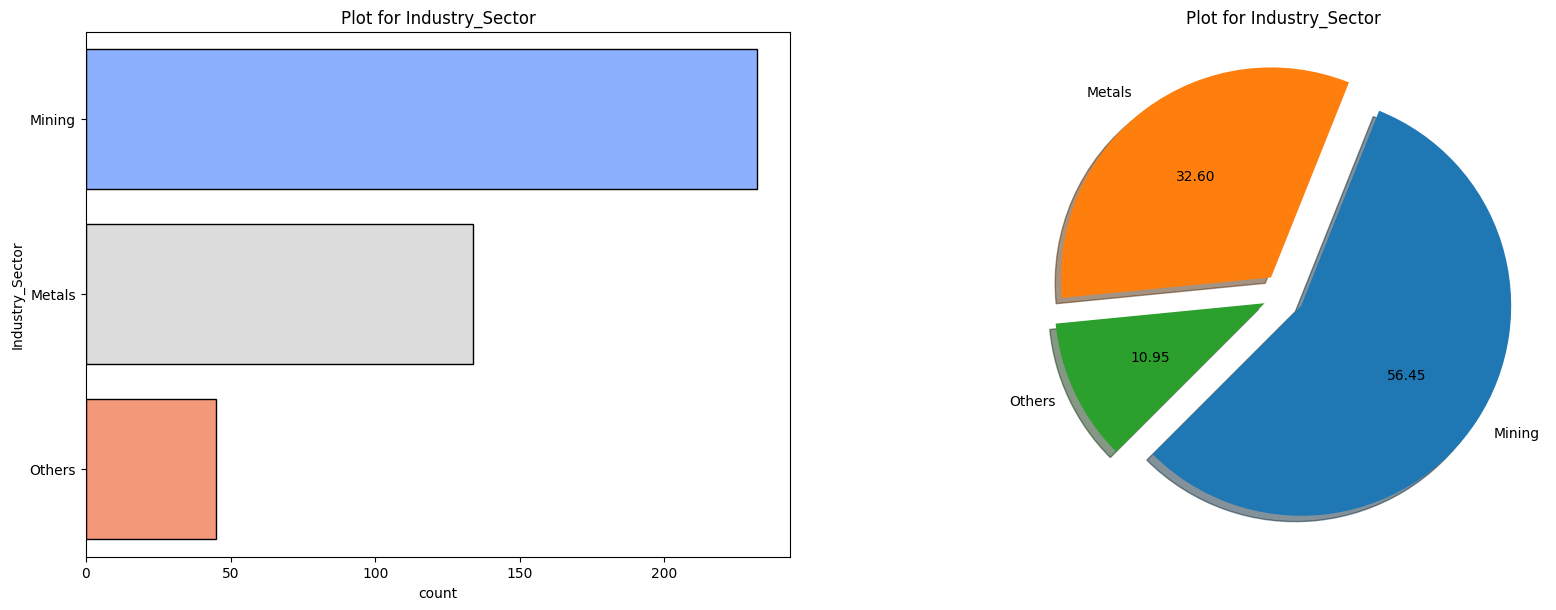

<Figure size 2000x1500 with 0 Axes>

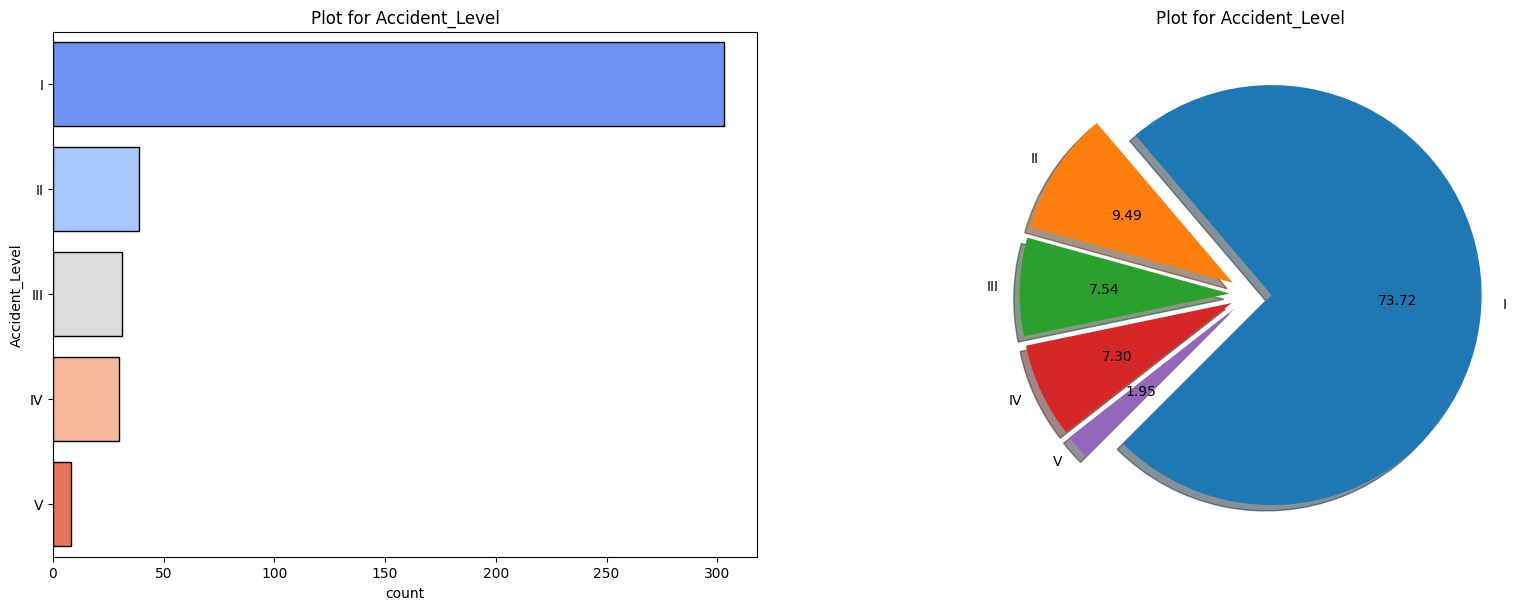

<Figure size 2000x1500 with 0 Axes>

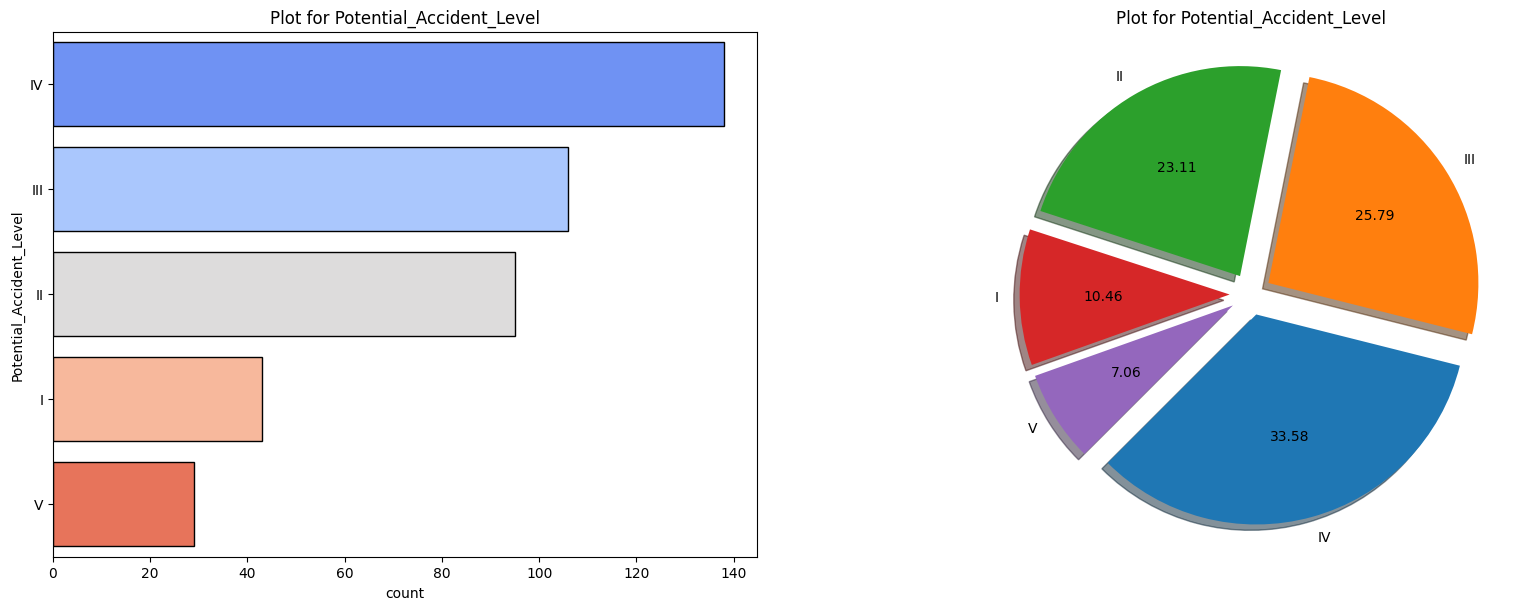

<Figure size 2000x1500 with 0 Axes>

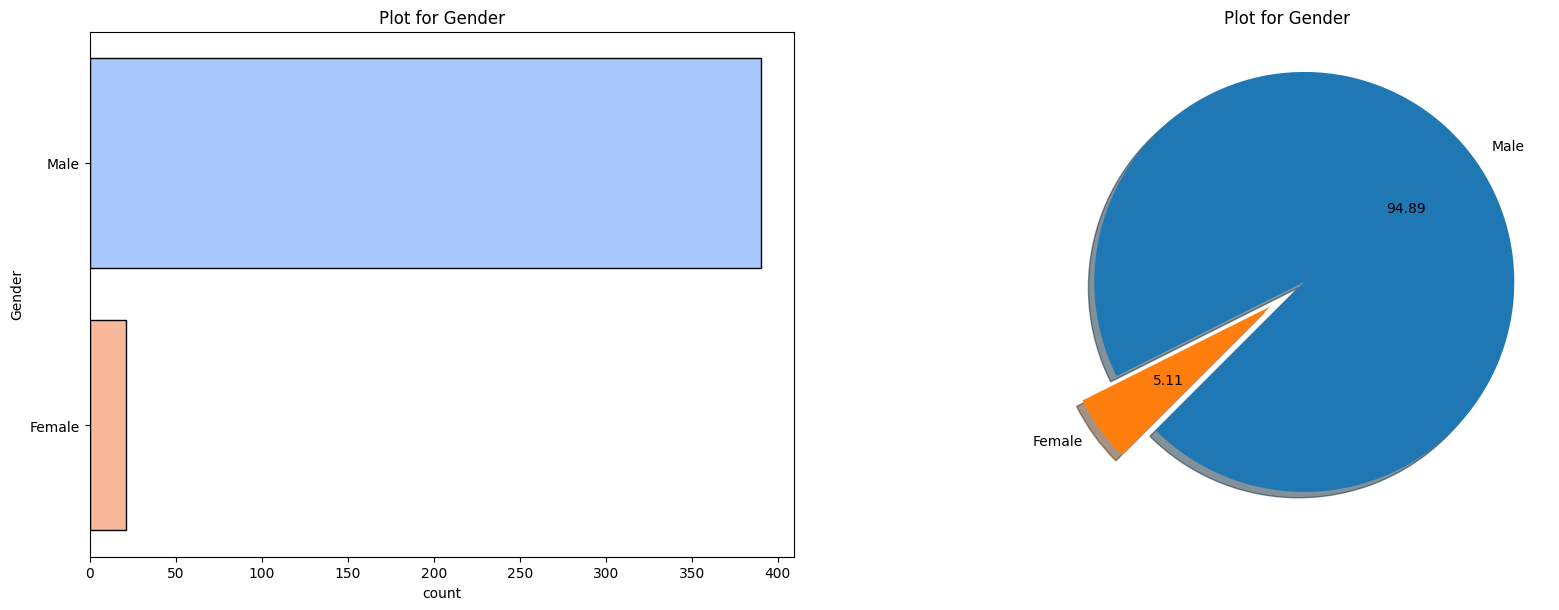

<Figure size 2000x1500 with 0 Axes>

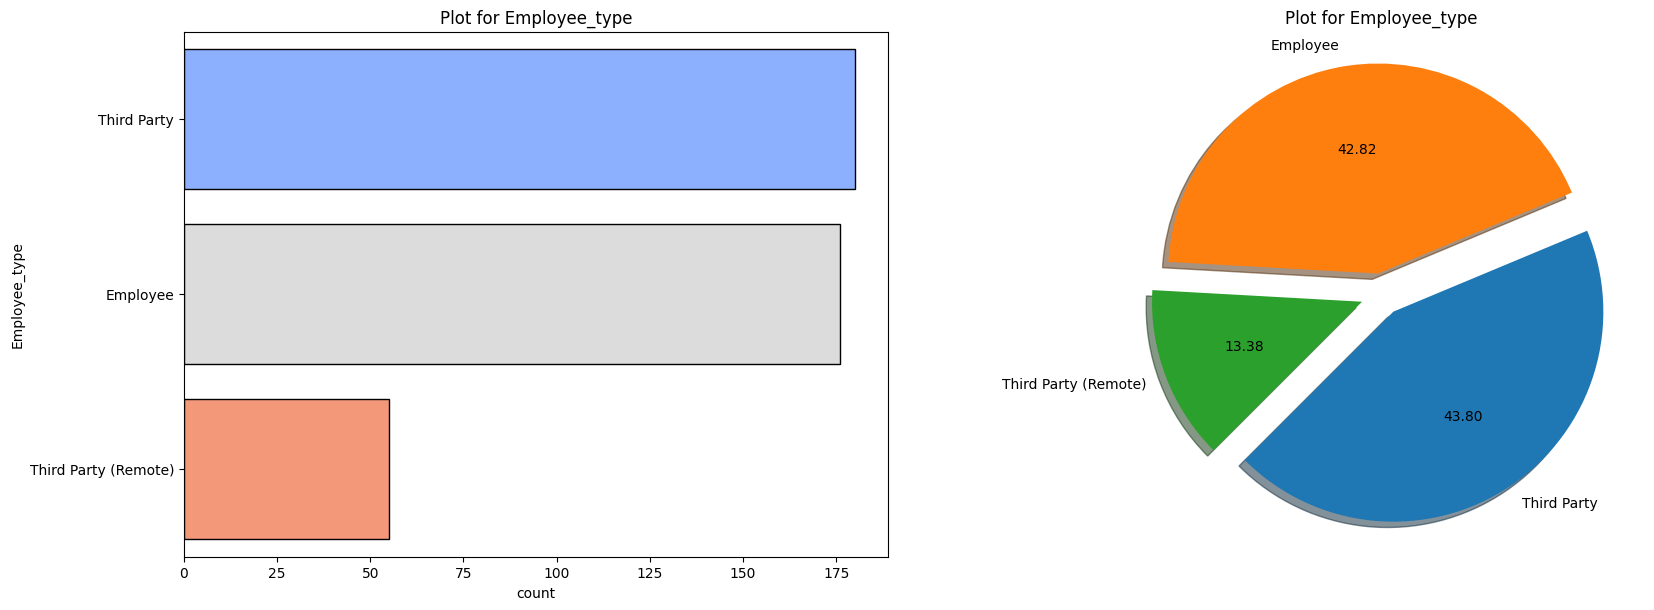

<Figure size 2000x1500 with 0 Axes>

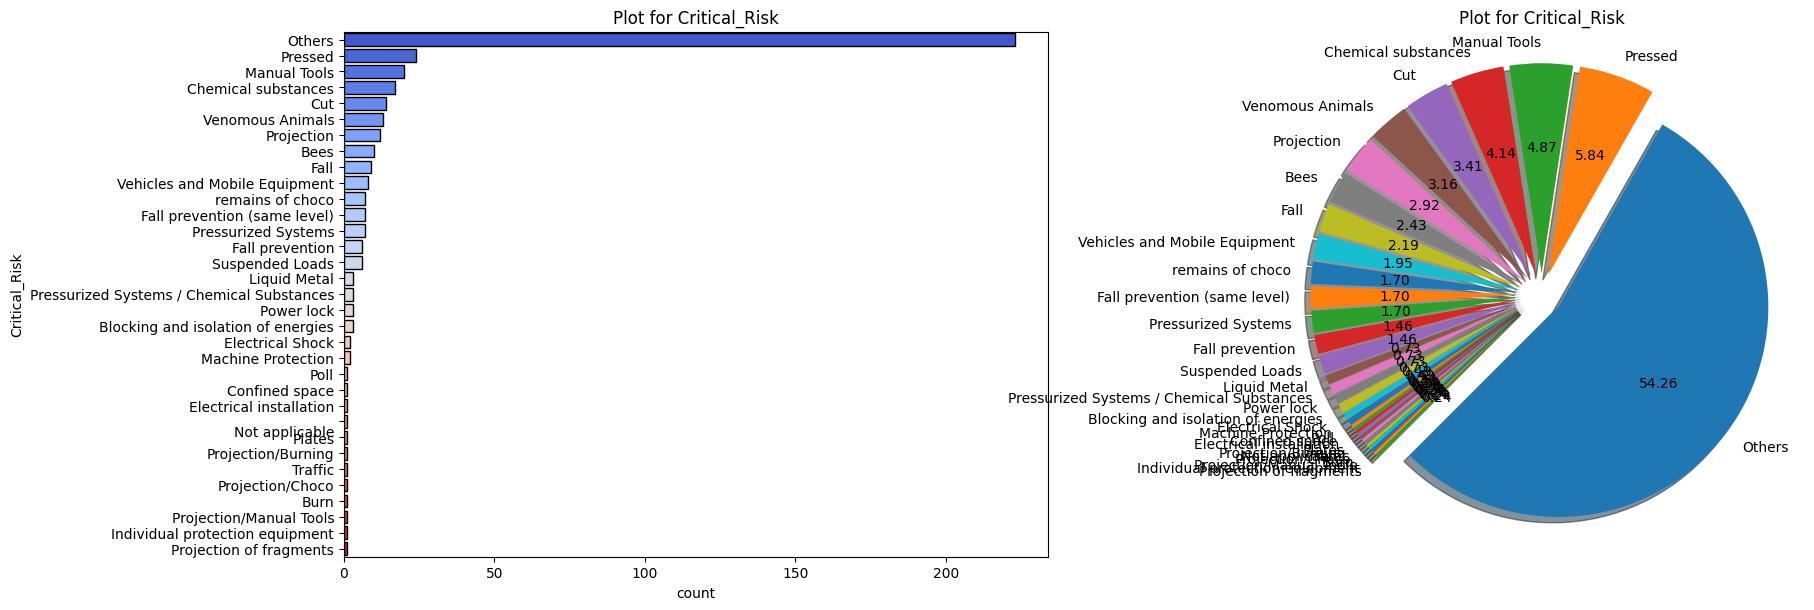

<Figure size 2000x1500 with 0 Axes>

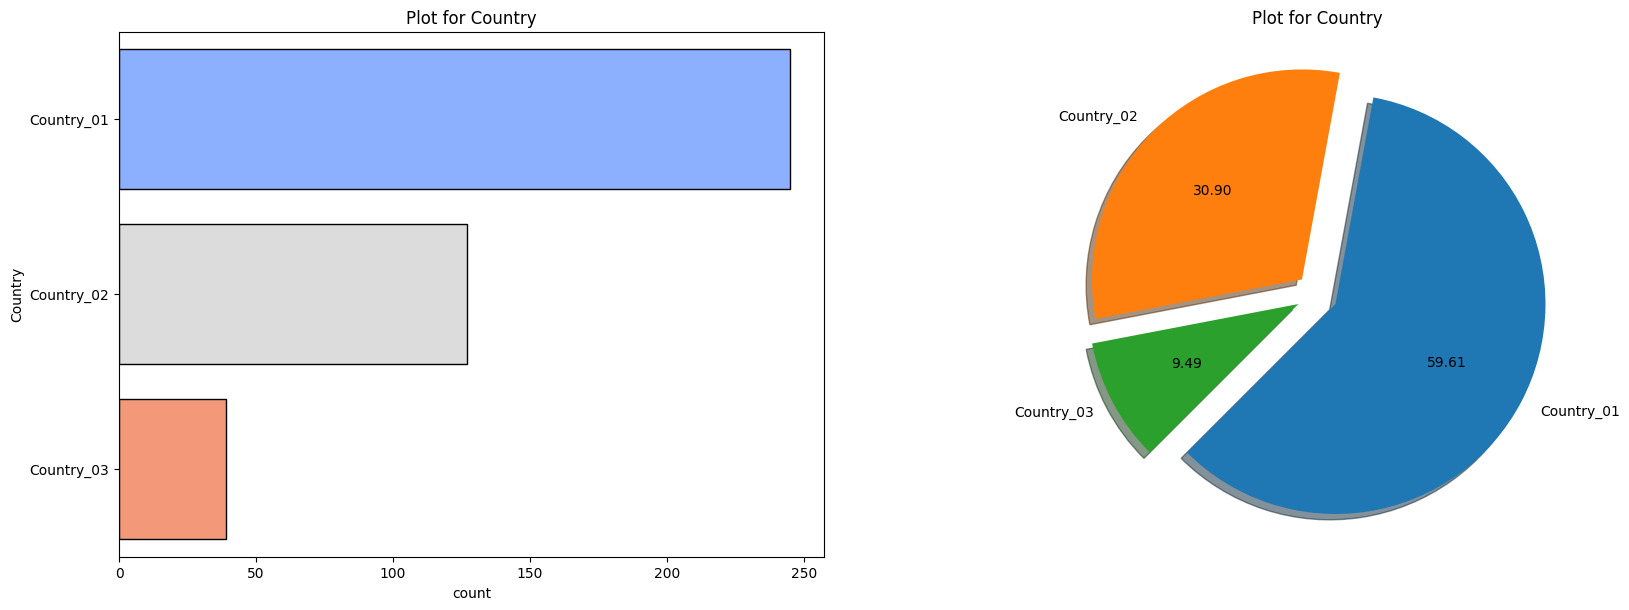

<Figure size 2000x1500 with 0 Axes>

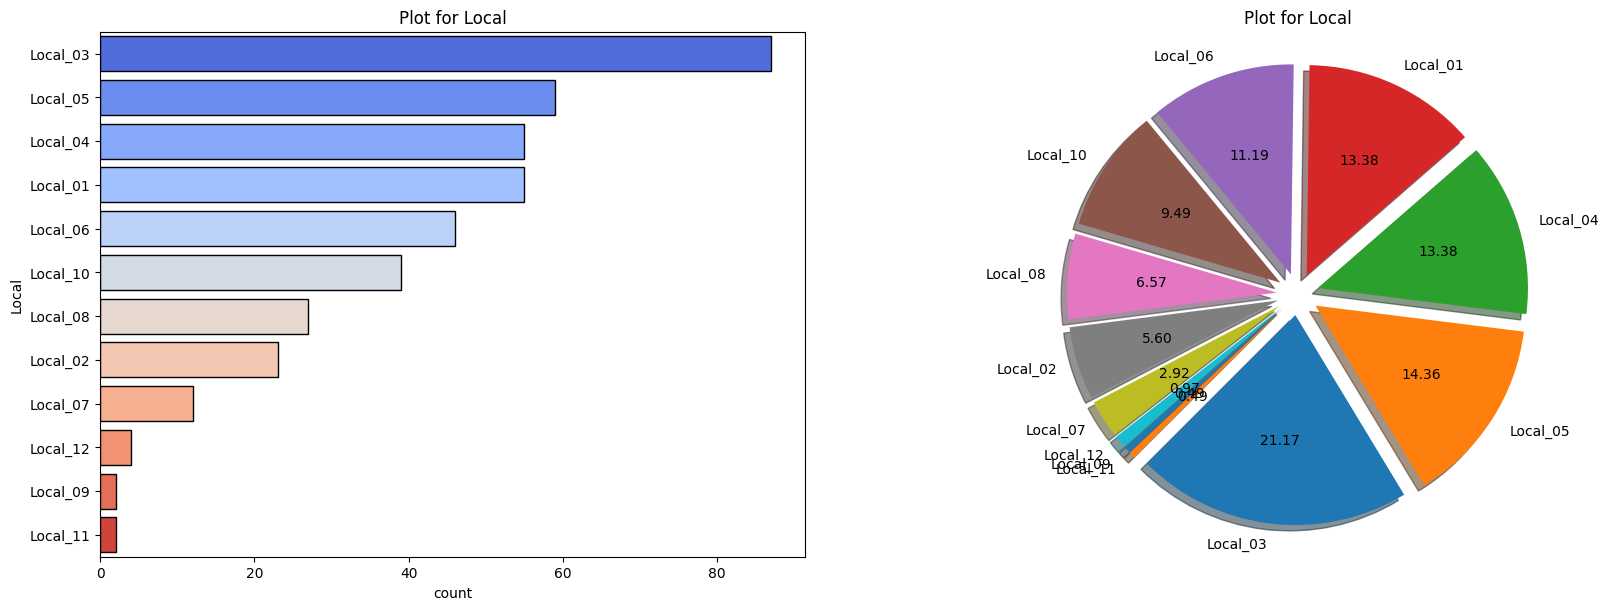

In [ ]:
# visualize the distribution of accidents based on country level
# we have total 3 countries so will use the pie chart to visualize the distribution
import plotly.graph_objects as go
import plotly.express as px
import holoviews as hv
from holoviews import opts


# @title Univariate analysis on 'Country', 'Local', 'Industry_Sector', 'Accident_Level','Potential_Accident_Level', 'Gender', 'Employee_Type', 'Critical_Risk'
# List of columns
columns_to_plot = ['Industry_Sector', 'Accident_Level', 'Potential_Accident_Level', 'Gender', 'Employee_type', 'Critical_Risk','Country','Local']

# Loop through each column and call the plot function
for col in columns_to_plot:
    plot(col, f"Plot for {col}", 'coolwarm', 'black')

In [ ]:
print('--'*50)
print('Total Country Wise Accident Counts:')
print('--'*50)

total_row_cnt = chatbot_database.shape[0]
country_01_cnt = chatbot_database[chatbot_database.Country == 'Country_01'].shape[0]
country_02_cnt = chatbot_database[chatbot_database.Country == 'Country_02'].shape[0]
country_03_cnt = chatbot_database[chatbot_database.Country == 'Country_03'].shape[0]

print(f'Country_01 count: {country_01_cnt} i.e. {round(country_01_cnt/total_row_cnt*100, 0)}%')
print(f'Country_02 count: {country_02_cnt} i.e. {round(country_02_cnt/total_row_cnt*100, 0)}%')
print(f'Country_03 count: {country_03_cnt} i.e. {round(country_03_cnt/total_row_cnt*100, 0)}%')

print('--'*50);
print('Distributon of Accidents Based On Country');
print('--'*50)

labels = ['Country_01','Country_02','Country_03']
values = [country_01_cnt,country_02_cnt,country_03_cnt]

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

----------------------------------------------------------------------------------------------------
Total Country Wise Accident Counts:
----------------------------------------------------------------------------------------------------
Country_01 count: 245 i.e. 60.0%
Country_02 count: 127 i.e. 31.0%
Country_03 count: 39 i.e. 9.0%
----------------------------------------------------------------------------------------------------
Distributon of Accidents Based On Country
----------------------------------------------------------------------------------------------------


From the above pie chart, we have observed the followings:
1.   **59%** of the total accidents occurred in **Country_01**
2.   **31%** of the total accidents occurred in **Country_02**
3.   **10%** of the total accidents occurred in **Country_03**

**EDA-2 - Count of Manufacturing Plants Based On Local**

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
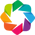

:Bars   [Local]   (count)

In [ ]:
local_cnt = np.round(chatbot_database['Local'].value_counts())

hv.extension('bokeh')
hv.Bars(local_cnt).opts(title="Local Count", color="#4CA3DD", xlabel="Locals", ylabel="Count of Accidents").opts(opts.Bars(width=1000, height=600,tools=['hover'],show_grid=True))


From the above count plot, we have observed the followings:


1.   **Maximum** number of manufacturing plants are located in **Local** 03
2.   **Lowest** number of manufacturing plants are located in **Local_09**

**EDA-3 - Distribution of Industry Based On Sector**

----------------------------------------------------------------------------------------------------
Value Counts for `Industry Sector`
----------------------------------------------------------------------------------------------------
Mining count: 232 i.e. 56.0%
Metals count: 134 i.e. 33.0%
Others count: 45 i.e. 11.0%
----------------------------------------------------------------------------------------------------
Distribution of Industry Based On Sector
----------------------------------------------------------------------------------------------------


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
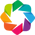

:Overlay
   .Bars.I   :Bars   [Industry_Sector]   (proportion)
   .Text.I   :Text   [x,y]
   .Text.II  :Text   [x,y]
   .Text.III :Text   [x,y]

In [ ]:
print('--'*50)
print('Value Counts for `Industry Sector`')
print('--'*50)

Mining_cnt = chatbot_database[chatbot_database['Industry_Sector'] == 'Mining'].shape[0]
Metals_cnt = chatbot_database[chatbot_database['Industry_Sector'] == 'Metals'].shape[0]
Others_cnt = chatbot_database[chatbot_database['Industry_Sector'] == 'Others'].shape[0]

print(f'Mining count: {Mining_cnt} i.e. {round(Mining_cnt/total_row_cnt*100, 0)}%')
print(f'Metals count: {Metals_cnt} i.e. {round(Metals_cnt/total_row_cnt*100, 0)}%')
print(f'Others count: {Others_cnt} i.e. {round(Others_cnt/total_row_cnt*100, 0)}%')

print('--'*50)
print('Distribution of Industry Based On Sector')
print('--'*50)

sector_cnt = np.round(chatbot_database['Industry_Sector'].value_counts(normalize=True) * 100)
hv.extension('bokeh')
hv.Bars(sector_cnt).opts(title="Industry Sector Count", color="#4CA3DD", xlabel="Sectors", ylabel="Percentage", yformatter='%d%%').opts(opts.Bars(width=500, height=300,tools=['hover'],show_grid=True))* hv.Text('Mining', 15, f"{int(sector_cnt.loc['Mining'])}%")* hv.Text('Metals', 15, f"{int(sector_cnt.loc['Metals'])}%")* hv.Text('Others', 15, f"{int(sector_cnt.loc['Others'])}%")

From the above countplot, we have observed the followings:


1.   **56%** manufacturing plants belongs to **Mining** sector
2.   **33%** manufacturing plants belongs to **Metals** sector
3.   **11%** manufacturing plants belongs to **Others** sector

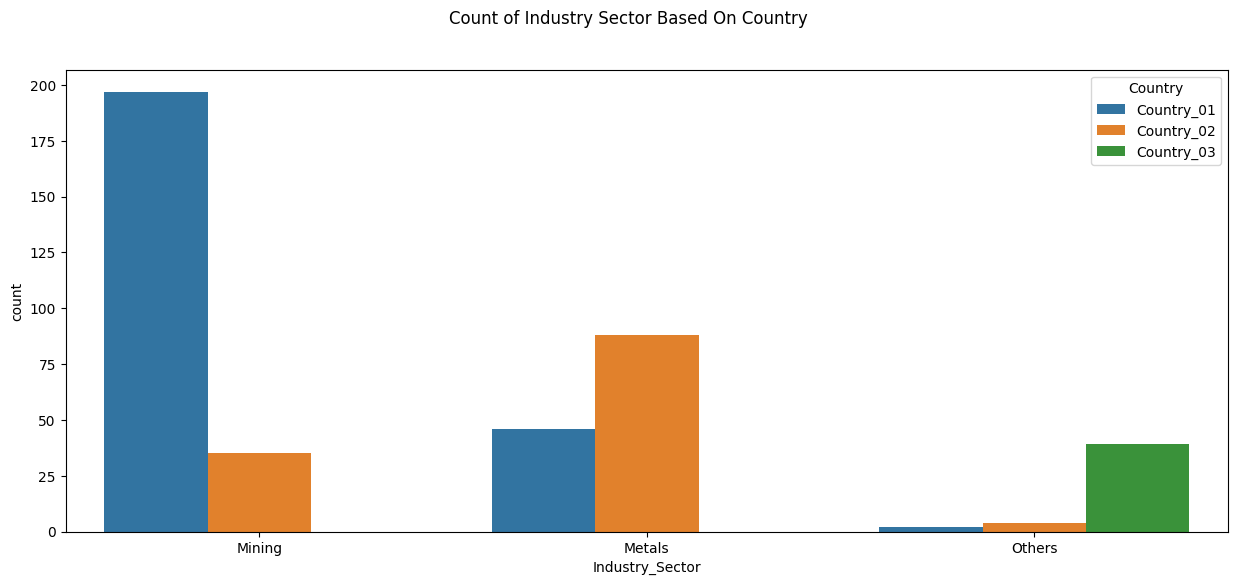

In [ ]:
plt.figure(figsize=(15,6))
plt.suptitle('Count of Industry Sector Based On Country')
ax = sns.countplot(x=chatbot_database['Industry_Sector'],data=chatbot_database,hue=chatbot_database['Country'])
plt.show();

Metals and Mining industry sector plants are not available in Country_03.

**EDA-4- Analysis of the Accident Level & Potential Accident Level**

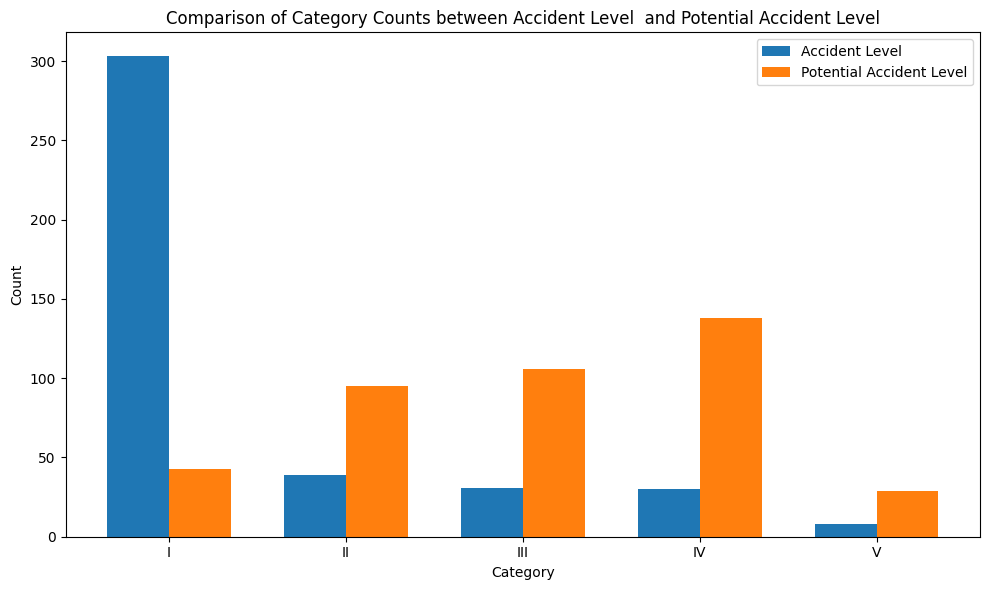

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

Accident_Level_count = chatbot_database['Accident_Level'].value_counts()


Potential_Accident_Level_count = chatbot_database['Potential_Accident_Level'].value_counts()


unique_categories = sorted(set(Accident_Level_count.index) | set(Potential_Accident_Level_count.index))

for category in unique_categories:
    if category not in Accident_Level_count:
        Accident_Level_count[category] = 0
    if category not in Potential_Accident_Level_count:
        Potential_Accident_Level_count[category] = 0

Accident_Level_count = Accident_Level_count.sort_index()
Potential_Accident_Level_count = Potential_Accident_Level_count.sort_index()

plt.figure(figsize=(10, 6))

bar_width = 0.35

indices = np.arange(len(unique_categories))

# Plot bars
plt.bar(indices - bar_width/2, Accident_Level_count, bar_width, label='Accident Level')
plt.bar(indices + bar_width/2, Potential_Accident_Level_count, bar_width, label='Potential Accident Level')

# Labeling
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Comparison of Category Counts between Accident Level  and Potential Accident Level')
plt.xticks(indices, unique_categories)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()



From the above bar plot, we have observed the followings:


1.   The number of accidents **decreases** as the Severity Level of Accident increases
2.   The number of accidents **increases** as the Potential Accident Level increases

**EDA-5 - The possibilities of lower level accidents turning into higher level accidents**

In [ ]:
from plotly.subplots import make_subplots

New_level_1=chatbot_database.groupby(['Accident_Level','Potential_Accident_Level']).size().to_frame('PAL_Count')
New_level_1.reset_index(inplace=True)



AL=New_level_1['Accident_Level'].unique()
row_max=2;col_max=3;n_row=1;n_col=1
fig = make_subplots(rows=row_max,cols=col_max,specs=[[{'type': 'pie'},{'type': 'pie'},{'type': 'pie'}],[{'type': 'pie'},{'type': 'pie'},{'type': 'pie'}]])

for AL_index in AL:
    labels=New_level_1[New_level_1['Accident_Level']==AL_index]['Potential_Accident_Level'].to_list()
    values=New_level_1[New_level_1['Accident_Level']==AL_index]['PAL_Count'].to_list()
    if(n_col>col_max):
        n_row=n_row+1
        n_col=1
    fig.add_trace(go.Pie(labels=labels, values=values,direction='clockwise',sort=False,name='PAL',title='Accident Level '+str(AL_index),titleposition='bottom center'), row=n_row, col=n_col)
    n_col+=1

fig.update_layout(height=600, width=800, title_text="The Percentage of Accident levels turning into Higher Potential Accident level")
fig.show()

Below are some insights that we can take from the above charts:-

1) There is 85.8% chances that accident level 1 can turn into a potential accident level greater than 1

2) For the accident level 2 also, it has higher chances (100-17.9=82.1%) of turning into major accidents

3) When the accident level is identified as 3, it is more likely to turn into higher Potential levels (100-9.68)=90.32

4) For the accident level 4, there is less than 30% chances that it turn into higher potential level accidents

5) For the accident level 5, there is no chance to turn into higher potential level accidents

It can be concluded that safety measures to be taken care to make the lower level (I, II, III) accidents to not to turn into major accidents as there are high chances 85.8%, 82.1% and 90.32%

**EDA-6 - Total Accidents Based Gender Wise**

----------------------------------------------------------------------------------------------------
Count of Accidents Gender Wise
----------------------------------------------------------------------------------------------------
Male count: 390 i.e. 95.0%
Female count: 21 i.e. 5.0%
----------------------------------------------------------------------------------------------------
Count of Accidents Gender Wise
----------------------------------------------------------------------------------------------------


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
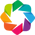

:Bars   [Gender]   (proportion)

In [ ]:
print('--'*50)
print('Count of Accidents Gender Wise')
print('--'*50)

Male_cnt = chatbot_database[chatbot_database['Gender'] == 'Male'].shape[0]
Female_cnt = chatbot_database[chatbot_database['Gender'] == 'Female'].shape[0]

print(f'Male count: {Male_cnt} i.e. {round(Male_cnt/total_row_cnt*100, 0)}%')
print(f'Female count: {Female_cnt} i.e. {round(Female_cnt/total_row_cnt*100, 0)}%')

print('--'*50)
print('Count of Accidents Gender Wise')
print('--'*50)

gender_cnt = np.round(chatbot_database['Gender'].value_counts(normalize=True) * 100)
hv.extension('bokeh')
hv.Bars(gender_cnt).opts(title="Gender Count", color="#4CA3DD", xlabel="Gender", ylabel="Percentage", yformatter='%d%%').opts(opts.Bars(width=300, height=300,tools=['hover'],show_grid=True))

From the above plot, we have obserbed that the proportion of Female workers is very less as compared to the Male workers.

Plot a graph to show Accidents Count by Country and Local group by and hue on gender

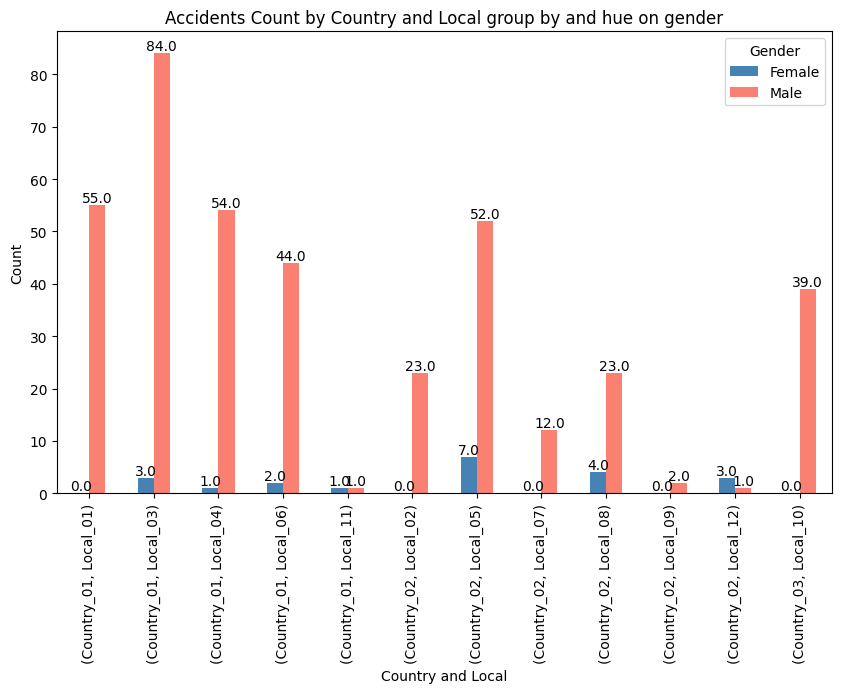

In [ ]:
# @title Plot a graph to show Accidents Count by Country and Local group by and hue on gender

# Group data by Country, Local, and Gender
grouped_data = chatbot_database.groupby(['Country', 'Local', 'Gender']).size().unstack()

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
grouped_data.plot(kind='bar', ax=ax, color=['steelblue', 'salmon'])

# Add labels and title
ax.set_xlabel('Country and Local')
ax.set_ylabel('Count')
ax.set_title('Accidents Count by Country and Local group by and hue on gender')

# Add annotations
for i, bar in enumerate(ax.patches):
    ax.annotate(str(bar.get_height()), (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='bottom')

plt.show()

----------------------------------------------------------------------------------------------------
Count of Employee Based On Employee Type
----------------------------------------------------------------------------------------------------
Third Party count: 180 i.e. 44.0%
Employee count: 176 i.e. 43.0%
Third Party (Remote) count: 55 i.e. 13.0%
----------------------------------------------------------------------------------------------------
Distribution of Employee Type
----------------------------------------------------------------------------------------------------


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
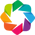

:Bars   [Employee_type]   (proportion)

In [ ]:
print('--'*50)
print('Count of Employee Based On Employee Type')
print('--'*50)

third_party_cnt = chatbot_database[chatbot_database['Employee_type'] == 'Third Party'].shape[0]
emp_cnt = chatbot_database[chatbot_database['Employee_type'] == 'Employee'].shape[0]
third_rem_cnt = chatbot_database[chatbot_database['Employee_type'] == 'Third Party (Remote)'].shape[0]

print(f'Third Party count: {third_party_cnt} i.e. {round(third_party_cnt/total_row_cnt*100, 0)}%')
print(f'Employee count: {emp_cnt} i.e. {round(emp_cnt/total_row_cnt*100, 0)}%')
print(f'Third Party (Remote) count: {third_rem_cnt} i.e. {round(third_rem_cnt/total_row_cnt*100, 0)}%')

print('--'*50)
print('Distribution of Employee Type')
print('--'*50)

# visualize the count of employees based on employee type
emp_type_cnt = np.round(chatbot_database['Employee_type'].value_counts(normalize=True) * 100)
hv.extension('bokeh')
hv.Bars(emp_type_cnt).opts(title="Employee type Count", color="#4CA3DD", xlabel="Employee Type", ylabel="Percentage", yformatter='%d%%').opts(opts.Bars(width=500, height=300,tools=['hover'],show_grid=True))

From the above plot, we have observed that the maximum number of employees are from Third Party and minimum is from Third Party (Remote).


1.   **44%** out of total employees are from **Third Party** type
2.   **43%** out of total employees are from **Employee** type
3.   **13%** out of total employees are from **Third Party (Remote)** type

**EDA-7 - Count of Accidents Based On Critical Risk**

----------------------------------------------------------------------------------------------------
Count of Accidents Based On Critical Risk
----------------------------------------------------------------------------------------------------
Critical_Risk
Others                                       223
Pressed                                       24
Manual Tools                                  20
Chemical substances                           17
Cut                                           14
Venomous Animals                              13
Projection                                    12
Bees                                          10
Fall                                           9
Vehicles and Mobile Equipment                  8
remains of choco                               7
Fall prevention (same level)                   7
Pressurized Systems                            7
Fall prevention                                6
Suspended Loads                                6
Liquid 

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
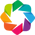

:Bars   [Critical_Risk]   (proportion)

In [ ]:
# count of accidents based on critical risk
print('--'*50)
print('Count of Accidents Based On Critical Risk')
print('--'*50)
print(chatbot_database['Critical_Risk'].value_counts())

print('--'*50)
print('Distriubution of the Accidents Based On Critical Risk')
print('--'*50)
cr_risk_cnt = np.round(chatbot_database['Critical_Risk'].value_counts(normalize=True) * 100)
hv.extension('bokeh')
hv.Bars(cr_risk_cnt[::-1]).opts(title="Critical Risk Count", color="#4CA3DD", xlabel="Critical Risks", ylabel="Percentage", xformatter='%d%%')\
                .opts(opts.Bars(width=600, height=600,tools=['hover'],show_grid=True,invert_axes=True))


From the above plot, we have observed that the maximum number of accidents i.e., 55% of total is falling under the Critical Risk 'Other'.

**EDA-8 - Analysis of Accidents Based On Month and Year**

----------------------------------------------------------------------------------------------------
Count of Accidents Year Wise
----------------------------------------------------------------------------------------------------
Year 2016 Count: 278 i.e. 68.0%
Year 2017 Count: 133 i.e. 32.0%
----------------------------------------------------------------------------------------------------
Distribution of Accidents Year Wise
----------------------------------------------------------------------------------------------------


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
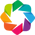

:Bars   [Year]   (proportion)

In [ ]:
print('--'*50)
print('Count of Accidents Year Wise')
print('--'*50)

year_2016 = chatbot_database[chatbot_database['Year'] == 2016].shape[0]
year_2017 = chatbot_database[chatbot_database['Year'] == 2017].shape[0]

print(f'Year 2016 Count: {year_2016} i.e. {round(year_2016/chatbot_database.shape[0]*100, 0)}%')
print(f'Year 2017 Count: {year_2017} i.e. {round(year_2017/chatbot_database.shape[0]*100, 0)}%')

print('--'*50)
print('Distribution of Accidents Year Wise')
print('--'*50)

# visualize the count of employees based on employee type
acc_count = np.round(chatbot_database['Year'].value_counts(normalize=True) * 100)
hv.extension('bokeh')
hv.Bars(acc_count).opts(title="Year Wise Accident Count", color="#4CA3DD", xlabel="Year", ylabel="Percentage", yformatter='%d%%')\
.opts(opts.Bars(width=300, height=300,tools=['hover'],show_grid=True))

From the above plot, we have observed that maximum number of accidents occurred in 2016 as compared to 2017.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
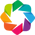

:Bars   [Month]   (proportion)

In [ ]:
month_cnt_2016 = np.round(chatbot_database[chatbot_database['Year']==2016]['Month'].value_counts(normalize=True,sort=False) * 100)
hv.extension('bokeh')
hv.Bars(month_cnt_2016).opts(title="Month Count: Year 2016", color="#FFA500", xlabel="Months", ylabel="Percentage", yformatter='%d%%')\
.opts(opts.Bars(width=1000, height=300,tools=['hover'],show_grid=True))

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
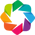

:Bars   [Month]   (proportion)

In [ ]:
month_cnt_2017 = np.round(chatbot_database[chatbot_database['Year']==2017]['Month'].value_counts(normalize=True,sort=False) * 100)
hv.extension('bokeh')
hv.Bars(month_cnt_2017).opts(title="Month Count: Year 2017", color="#FFA500", xlabel="Months", ylabel="Percentage", yformatter='%d%%')\
.opts(opts.Bars(width=1000, height=300,tools=['hover'],show_grid=True))

From the above plot, we have observed that the number of accidents recorded is maximum in the first half of each year as compared to the second half.

**EDA-9 - The number of accidents with time (Year and Month)**

In [ ]:
#Taking count with Year and month wise
month_data_1=pd.DataFrame(chatbot_database.groupby(['Year','Month'])['Month'].value_counts())
month_data_1.rename(columns={'Month':'Count'},inplace=True)
month_data_1.head()



count
Year Month       
2016 1         12
     2         30
     3         34
     4         28
     5         25

In [ ]:
#To get the index chronological order Year and month are taken from multi_index
new_1=pd.DataFrame(month_data_1.index.to_frame()[['Year','Month']])
new_1=new_1.astype({"Year": str, "Month": str})



In [ ]:
new_1.head()

Year Month
Year Month            
2016 1      2016     1
     2      2016     2
     3      2016     3
     4      2016     4
     5      2016     5

In [ ]:
#Getting the index column as 'Year_Month' format
new_1['new_col']=new_1['Year']+'_'+new_1['Month']
month_data_1['Year_Month']=new_1['new_col']

month_data_1.head(5)



count Year_Month
Year Month                  
2016 1         12     2016_1
     2         30     2016_2
     3         34     2016_3
     4         28     2016_4
     5         25     2016_5

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
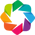

:Bars   [Year_Month]   (count)

In [ ]:
new_2=pd.DataFrame(month_data_1[['count','Year_Month']]).set_index(keys='Year_Month')
hv.extension('bokeh')
hv.Bars(new_2).opts(title="Number of Accidents with time", color="#4CA3DD", xlabel="Year and Month", ylabel="Count of Accidents").opts(opts.Bars(width=1000, height=600,tools=['hover'],show_grid=True))

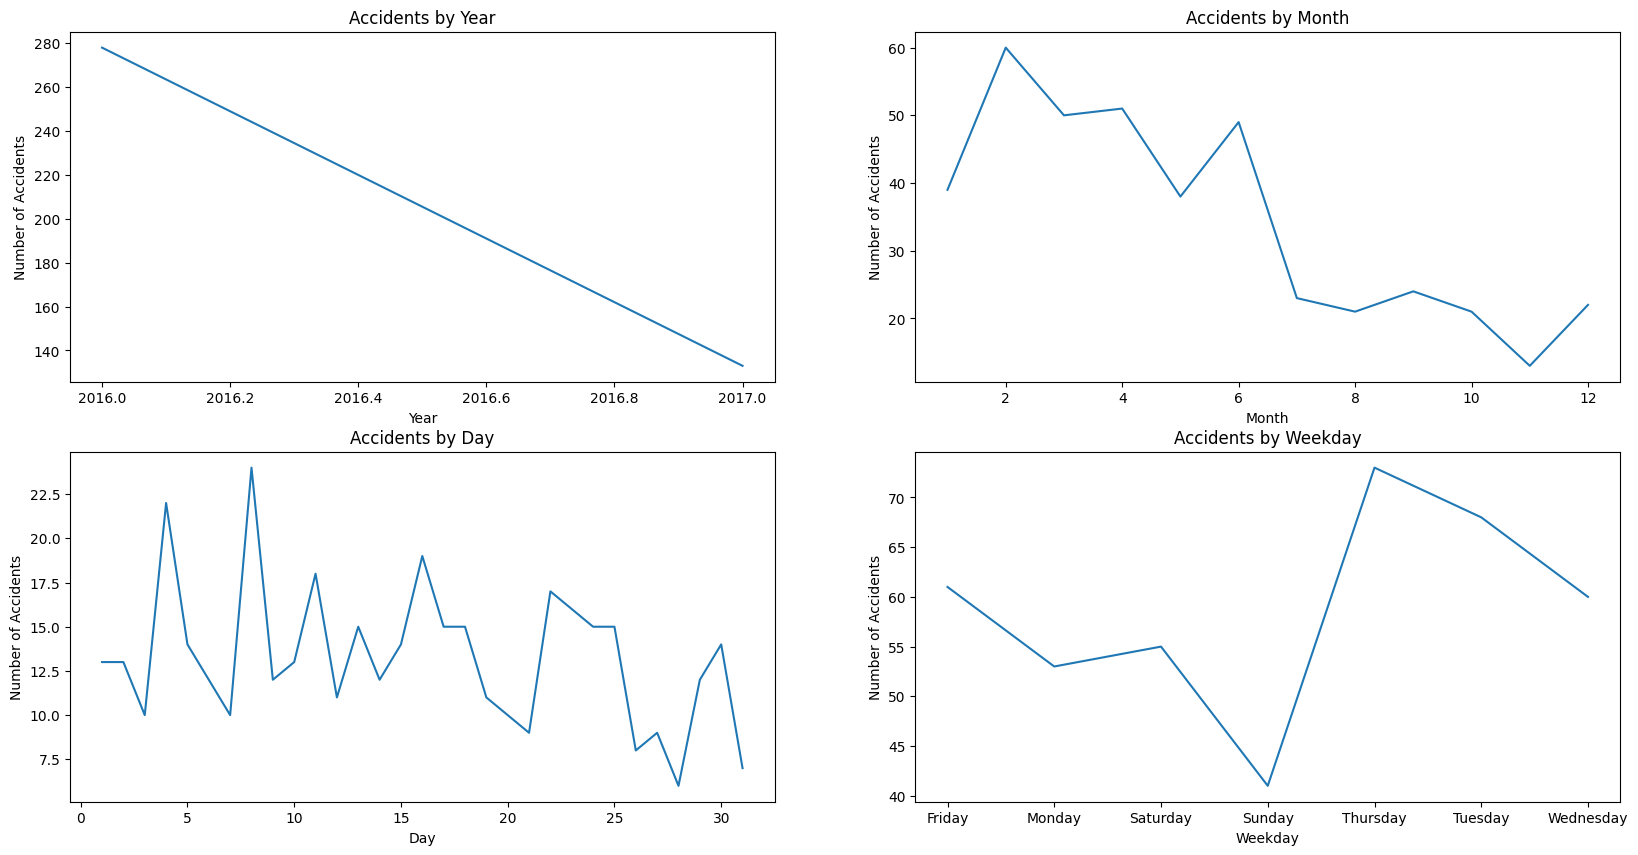

In [ ]:
# @title generate four charts in the same code one for year wise and one monthly , one daily and one weekday

import matplotlib.pyplot as plt

# Create a figure with four subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# Plot accidents by year
chatbot_database.groupby('Year')['Country'].count().plot(ax=axes[0, 0], title='Accidents by Year')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Accidents')

# Plot accidents by month
chatbot_database.groupby('Month')['Country'].count().plot(ax=axes[0, 1], title='Accidents by Month')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of Accidents')

# Plot accidents by day
chatbot_database.groupby('Day')['Country'].count().plot(ax=axes[1, 0], title='Accidents by Day')
axes[1, 0].set_xlabel('Day')
axes[1, 0].set_ylabel('Number of Accidents')

# Plot accidents by weekday
chatbot_database.groupby('Weekday')['Country'].count().plot(ax=axes[1, 1], title='Accidents by Weekday')
axes[1, 1].set_xlabel('Weekday')
axes[1, 1].set_ylabel('Number of Accidents')

# Show the plot
plt.show()


From the above chart, we can see that the first half of 2016 and first half of 2017, the number of accidents are on a higher side and then it is decreasing towards the end of year. We can also interpret that in summer and Autumn, the accidents count are on a higher side in comparison to winter and spring seasons.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
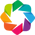

:Overlay
   .Bars.I  :Bars   [Day]   (proportion)
   .Curve.I :Curve   [Day]   (proportion)

In [ ]:
day_cnt = np.round(chatbot_database['Day'].value_counts(normalize=True,sort=False) * 100)
hv.extension('bokeh')
hv.Bars(day_cnt).opts(title="Day Count", color="#4CA3DD", xlabel="Days")* hv.Curve(day_cnt).opts(width=1000, height=300, color='red', line_width=3)\
.opts(opts.Bars(width=1000, height=300,tools=['hover'],show_grid=True))

From the above plot, we have observed that number of accidents are quite high in first half of the month in comparison to 2nd half of the month.

**EDA-10 - Counts of Accidents Based On WeekDay**

----------------------------------------------------------------------------------------------------
Countplot of Accidents Based On WeekDay
----------------------------------------------------------------------------------------------------


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
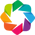

:Bars   [Weekday]   (count)

In [ ]:
week_cnts = chatbot_database['Weekday'].value_counts()
print('--'*50)
print('Countplot of Accidents Based On WeekDay')
print('--'*50)
hv.extension('bokeh')
hv.Bars(week_cnts).opts(title="Week Count", color="#00CED1", xlabel="WeekDay", ylabel="Week Count", yformatter='%d%%')\
.opts(opts.Bars(width=1000, height=300,tools=['hover'],show_grid=True))

We have observed that number of accidents increased during the middle of the week and declined after the middle of the week. This indicates that workers are getting tried till middle of the week which cause more accidents.

**EDA-11 - Counts of Accidents Based On Season**

----------------------------------------------------------------------------------------------------
Count of Accidents Season Wise
Season
Summer    171
Autumn    138
Spring     58
Winter     44
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
Countplot of Accidents Season Wise
----------------------------------------------------------------------------------------------------


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
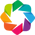

:Bars   [Season]   (count)

In [ ]:
print('--'*50)
print('Count of Accidents Season Wise')
season_cnt = chatbot_database['Season'].value_counts()
print(season_cnt)
print('--'*50)
print('Countplot of Accidents Season Wise')
print('--'*50)
hv.extension('bokeh')
hv.Bars(season_cnt).opts(title="Season Wise Accident Count", color="#4CA3DD", xlabel="Season", ylabel="Accident Count", yformatter='%d%%')\
.opts(opts.Bars(width=600, height=300,tools=['hover'],show_grid=True))

Maximum number of Accidents reported in summer season and minimum number is reported in winter season.

**EDA-12 - Plot a heatmap to get the Count of Accidents grouped by Accident Level and Potential accident level**

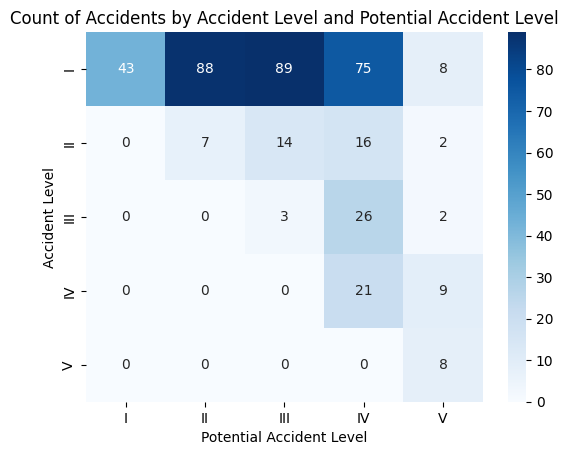

In [ ]:
# Create a crosstab of Accident Level and Potential Accident Level
accident_potential_crosstab = pd.crosstab(chatbot_database['Accident_Level'], chatbot_database['Potential_Accident_Level'])

# Plot the heatmap
sns.heatmap(accident_potential_crosstab, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Potential Accident Level')
plt.ylabel('Accident Level')
plt.title('Count of Accidents by Accident Level and Potential Accident Level')
plt.show()

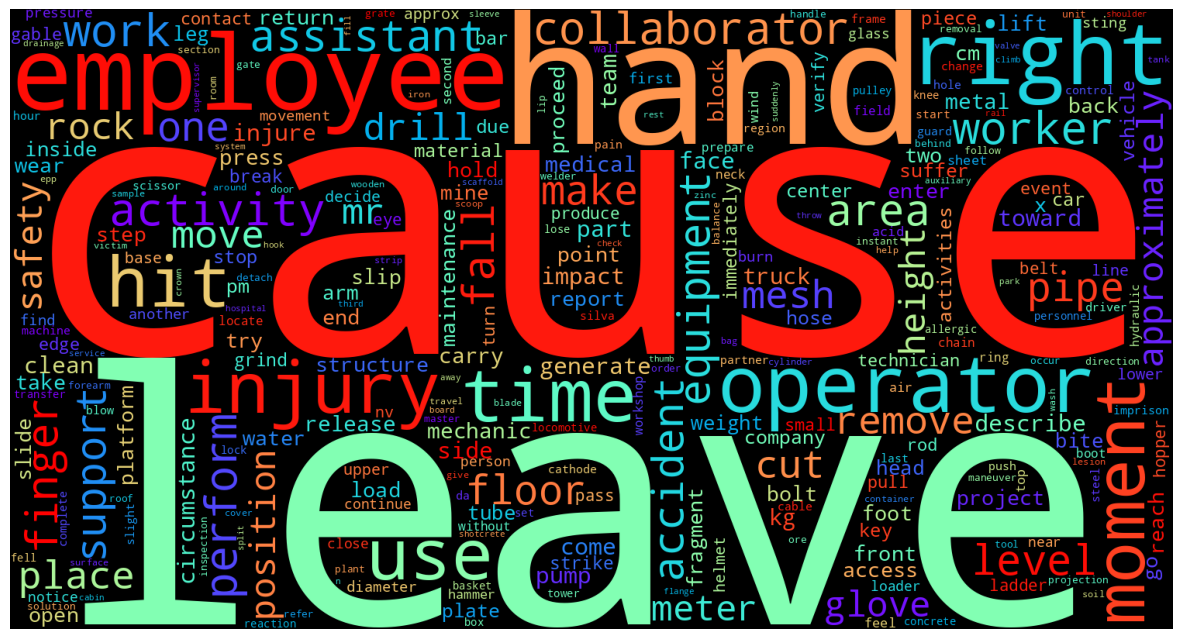

In [ ]:
# @title WordCloud
# Join the tokens in each list into a single string for each row
chatbot_database['Description_preprocess'] = chatbot_database['Description_preprocess'].apply(' '.join)

# Generate the wordcloud from the joined strings
wordcloud = WordCloud(width = 1500, height = 800, random_state=0, background_color='black', colormap='rainbow', \
                      min_font_size=5, max_words=300, collocations=False).generate(" ".join(chatbot_database['Description_preprocess'].values))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Observation for the above wordcloud

In [ ]:
# @title Observation for the above wordcloud

print("Observations:")
print("- The most frequent words in the accident descriptions are 'cause', 'leave', 'hand', 'injury', and 'employee'.")
print("- This suggests that many of the accidents involve employee using their hands to operate machinery, and that these accidents often result in cuts or other injuries to the hands.")
print("- Other common words include 'finger', 'face', 'foot', and 'head', suggesting that other parts of the body are also frequently injured in accidents.")
print("- The presence of words like 'fall', 'slip', and 'struck' suggests that many accidents are caused by workers falling, slipping, or being struck by objects.")
print("- Overall, the word cloud provides a useful visual summary of the types of accidents that are most common in this dataset.")

Observations:
- The most frequent words in the accident descriptions are 'cause', 'leave', 'hand', 'injury', and 'employee'.
- This suggests that many of the accidents involve employee using their hands to operate machinery, and that these accidents often result in cuts or other injuries to the hands.
- Other common words include 'finger', 'face', 'foot', and 'head', suggesting that other parts of the body are also frequently injured in accidents.
- The presence of words like 'fall', 'slip', and 'struck' suggests that many accidents are caused by workers falling, slipping, or being struck by objects.
- Overall, the word cloud provides a useful visual summary of the types of accidents that are most common in this dataset.


## **EDA Summary**

Following are the insights extracted by doing the EDA on the dataset :-

* Highest manufacturing plants are located in Local_03 city and lowest in Local_09 city.

* Percentage(%) of accidents occurred in respective countries: 59% in Country_01, 31% in Country_02 and 10% in Country_03.

* Percentage(%) of manufacturing plants belongs to respective sectors: 56% to Mining sector, 33% to Metals sector and 11% to Others sector.

* Metals and Mining industry sector plants are not available in Country_03.
Distribution of industry sector differ significantly in each country.

* The number of accidents decreases as the Accident Level increases and increases as the Potential Accident Level increases.

* There are more men working in this industry as compared to women.

* 44% Third party empoyees, 43% own empoyees and 13% Third party(Remote) empoyees working in this industry.

* Proportion of third party employees in each gender is equal, third party(remote) employees in each gender is not equal and own employees in each gender is not equal.

* Maximum number of accidents occurred in 2016 as compared to 2017.

* Number of accidents are high in summer and autumn and less in spring and winter

* Number of accidents increased during the middle of the week and declined after the middle of the week. This indicates that workers are getting tried till middle of the week which cause more accidents.

* Most of the critical risks are classified as Others.

## Generate for accident level

In [ ]:
synthetic_data=pd.DataFrame()
augmented_data=chatbot_database.copy()

In [ ]:
import pandas as pd
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from tqdm import tqdm

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "OPENAI_API_KEY"

In [ ]:
model_name='gpt2'
model=GPT2LMHeadModel.from_pretrained(model_name).to(device)
tokenizer=GPT2Tokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# @title Identify Minority Class
potential_levels_counts=chatbot_database['Potential_Accident_Level'].value_counts()
minority_potential_levels = potential_levels_counts[potential_levels_counts < 100].index.tolist()

## Identify Majority Class and Generate Synthetic Samples

In [ ]:
majority_class_count_pal=potential_levels_counts.max()
majority_class_count_pal

138

## Function to create the synthtic samples

In [ ]:
# @title Function to create the synthtic samples
def generate_synthetic_samples(data, column, class_label, num_samples):
  sample_data=data[data[column] == class_label]
  examples=sample_data['Description'].to_list()
  synthetic_samples=[]

  for _ in range(num_samples):
    input_text=examples[_ % len(examples)]
    input_ids=tokenizer.encode(input_text, return_tensors='pt').to(device)
    attention_mask=torch.ones(input_ids.shape,dtype=torch.long).to(device)

    with torch.no_grad():
      outputs=model.generate(
          input_ids,
          attention_mask=attention_mask,
          max_length=512,
          num_return_sequences=1,
          no_repeat_ngram_size=2,
          num_beams=3,
          early_stopping=False,
          pad_token_id=tokenizer.eos_token_id)
      synthetic_text=tokenizer.decode(outputs[0].cpu(), skip_special_tokens=True)
      synthetic_samples.append(synthetic_text)

  synthetic_df= sample_data.copy().iloc[:num_samples].reset_index(drop=True)
  synthetic_df['Description']=synthetic_samples[:len(synthetic_df)]
  return synthetic_df

print("Synthetic Samples Generation Fucntion Defined")

Synthetic Samples Generation Fucntion Defined


In [ ]:
!pip install tqdm

## Generate Synthetic samples for Potential accident level

In [ ]:
# @title Generate Synthetic samples for Potential accident level
synthetic_data=pd.DataFrame()
augmented_data=chatbot_database.copy()

In [ ]:
from tqdm import tqdm
for level in tqdm(minority_potential_levels, desc="Generating remaining synthetic samples"):
    num_samples_to_generate = majority_class_count_pal-len(augmented_data[augmented_data['Potential_Accident_Level'] == level])
    synthetic_samples = generate_synthetic_samples(chatbot_database, 'Potential_Accident_Level', level,num_samples_to_generate)
    augmented_data = pd.concat([augmented_data, synthetic_samples], ignore_index=True)

Generating remaining synthetic samples: 100%|██████████| 3/3 [10:35<00:00, 211.89s/it]


In [ ]:
from tqdm import tqdm
for level in tqdm(minority_potential_levels, desc="Generating remaining synthetic samples"):
    num_samples_to_generate = majority_class_count_pal-len(augmented_data[augmented_data['Potential_Accident_Level'] == level])
    synthetic_samples = generate_synthetic_samples(chatbot_database, 'Potential_Accident_Level', level,num_samples_to_generate)
    augmented_data = pd.concat([augmented_data, synthetic_samples], ignore_index=True)

Generating remaining synthetic samples: 100%|██████████| 3/3 [05:44<00:00, 114.83s/it]


In [ ]:
potential_accident_level_counts = augmented_data['Potential_Accident_Level'].value_counts()
print(potential_accident_level_counts)

Potential_Accident_Level
IV     138
II     138
I      129
III    106
V       87
Name: count, dtype: int64


In [ ]:
from tqdm import tqdm
for level in tqdm(minority_potential_levels, desc="Generating remaining synthetic samples"):
    num_samples_to_generate = majority_class_count_pal-len(augmented_data[augmented_data['Potential_Accident_Level'] == level])
    synthetic_samples = generate_synthetic_samples(chatbot_database, 'Potential_Accident_Level', level,num_samples_to_generate)
    augmented_data = pd.concat([augmented_data, synthetic_samples], ignore_index=True)

Generating remaining synthetic samples: 100%|██████████| 3/3 [02:31<00:00, 50.65s/it]


In [ ]:
from tqdm import tqdm
for level in tqdm(minority_potential_levels, desc="Generating remaining synthetic samples"):
    num_samples_to_generate = majority_class_count_pal-len(augmented_data[augmented_data['Potential_Accident_Level'] == level])
    synthetic_samples = generate_synthetic_samples(chatbot_database, 'Potential_Accident_Level', level,num_samples_to_generate)
    augmented_data = pd.concat([augmented_data, synthetic_samples], ignore_index=True)

Generating remaining synthetic samples: 100%|██████████| 3/3 [00:54<00:00, 18.27s/it]


In [ ]:
from tqdm import tqdm
for level in tqdm(minority_potential_levels, desc="Generating remaining synthetic samples"):
    num_samples_to_generate = majority_class_count_pal-len(augmented_data[augmented_data['Potential_Accident_Level'] == level])
    synthetic_samples = generate_synthetic_samples(chatbot_database, 'Potential_Accident_Level', level,num_samples_to_generate)
    augmented_data = pd.concat([augmented_data, synthetic_samples], ignore_index=True)

Generating remaining synthetic samples: 100%|██████████| 3/3 [00:00<00:00, 272.29it/s]


In [ ]:
num_samples_to_generate=majority_class_count_pal-len(augmented_data[augmented_data['Potential_Accident_Level'] == 'III'])
synthetic_samples = generate_synthetic_samples(chatbot_database,'Potential_Accident_Level','III',num_samples_to_generate)
augmented_data = pd.concat([augmented_data, synthetic_samples],ignore_index=True)

In [ ]:
potential_accident_level_counts = augmented_data['Potential_Accident_Level'].value_counts()
print(potential_accident_level_counts)

Potential_Accident_Level
IV     138
III    138
I      138
II     138
V      138
Name: count, dtype: int64


Now, we can save the dataset in csv format

In [ ]:
augmented_data.to_csv('chatbot_database_with_Cleansed_data.csv', index=False)

In [ ]:
augmented_data.head()

Date     Country     Local Industry_Sector Accident_Level  \
0 2016-01-01  Country_01  Local_01          Mining              I   
1 2016-01-02  Country_02  Local_02          Mining              I   
2 2016-01-06  Country_01  Local_03          Mining              I   
3 2016-01-08  Country_01  Local_04          Mining              I   
4 2016-01-10  Country_01  Local_04          Mining             IV   

  Potential_Accident_Level Gender         Employee_type        Critical_Risk  \
0                       IV   Male           Third Party              Pressed   
1                       IV   Male              Employee  Pressurized Systems   
2                      III   Male  Third Party (Remote)         Manual Tools   
3                        I   Male           Third Party               Others   
4                       IV   Male           Third Party               Others   

                                         Description  Year  Month  Day  \
0  While removing the drill rod of the Jumbo 08 f...  2016      1    1   
1  During the activation of a sodium sulphide pum...  2016      1    2   
2  In the sub-station MILPO located at level +170...  2016      1    6   
3  Being 9:45 am. approximately in the Nv. 1880 C...  2016      1    8   
4  Approximately at 11:45 a.m. in circumstances t...  2016      1   10   

     Weekday  WeekofYear  Season  \
0     Friday          53  Summer   
1   Saturday          53  Summer   
2  Wednesday           1  Summer   
3     Friday           1  Summer   
4     Sunday           1  Summer   

                              Description_preprocess  
0  remove drill rod jumbo 08 maintenance supervis...  
1  activation sodium sulphide pump pip uncouple s...  
2  substation milpo locate level 170 collaborator...  
3  945 approximately nv 1880 cx695 ob7 personnel ...  
4  approximately 1145 circumstances mechanics ant...

#  **Step 5: Design train and test basic machine learning classifiers**

## Machine Learning Models

In [ ]:
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay  # Import ConfusionMatrixDisplay  from the correct module

import pandas as pd

def ml_models(X_train, y_train, X_test, y_test):
    # Dictionary with different ML models
    models = {
        'LogReg': LogisticRegression(),
        'Naive Bayes': GaussianNB(),
        'KNN': KNeighborsClassifier(),
        'SVM': SVC(),
        'Decision Tree': DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=100, min_samples_leaf=5),
        'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=7),
        'Bagging': BaggingClassifier(n_estimators=50, max_samples=0.7),
        'AdaBoost': AdaBoostClassifier(n_estimators=50),
        'Gradient Boost': GradientBoostingClassifier(n_estimators=50, learning_rate=0.05),
        'XGBoost': XGBClassifier(enable_categorical=True) # Enable categorical data handling for XGBoost
    }

    names = []
    train_accuracy = []
    test_accuracy = []
    F1_score = []
    Precision = []
    Recall = []

    for name, model in models.items(): # Looping through each model
        clf = model.fit(X_train, y_train) # Fit the models one by one
        tr_accuracy = clf.score(X_train, y_train)
        te_accuracy = clf.score(X_test, y_test)
        y_pred = clf.predict(X_test)
        F1_sre = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        print(f"Model: {name}")
        print(classification_report(y_test, y_pred))

        cm_display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
        cm_display.plot()

        names.append(name)
        train_accuracy.append(tr_accuracy)
        test_accuracy.append(te_accuracy)
        F1_score.append(F1_sre)
        Precision.append(precision)
        Recall.append(recall)

    combined_model_result = pd.DataFrame({
        'Model': names,
        'Train_accuracy': train_accuracy,
        'Test_accuracy': test_accuracy,
        'F1_score': F1_score,
        'Precision': Precision,
        'Recall': Recall
    })

    return combined_model_result # Returns the dataframe

In [ ]:
final_database = pd.read_csv("chatbot_database_with_Cleansed_data.csv")

Let's take 'Potential Accident Level' column as target variables and try to build ML model based on that

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_database['Description_preprocess'], final_database['Potential_Accident_Level'].values, test_size=0.2, random_state=42)

In [ ]:
print('Count of training data: {}'.format(X_train.shape[0]))
print('Count of validation data: {}'.format(X_test.shape[0]))

Count of training data: 552
Count of validation data: 138


In [ ]:
# Initializing TfidfVectorizer object
tfIdfVectorizer = TfidfVectorizer()
X_train_tf = tfIdfVectorizer.fit_transform(X_train)
X_test_tf = tfIdfVectorizer.transform(X_test)

Model: LogReg
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       0.90      0.90      0.90        29
           2       0.77      0.83      0.80        29
           3       0.84      0.75      0.79        36
           4       0.96      1.00      0.98        23

    accuracy                           0.88       138
   macro avg       0.89      0.89      0.89       138
weighted avg       0.88      0.88      0.88       138

Model: Naive Bayes
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       0.87      0.93      0.90        29
           2       0.91      0.72      0.81        29
           3       0.79      0.83      0.81        36
           4       0.96      1.00      0.98        23

    accuracy                           0.88       138
   macro avg       0.90      0.90      0.89       138
weighted avg       0.89      0.88      0.88 

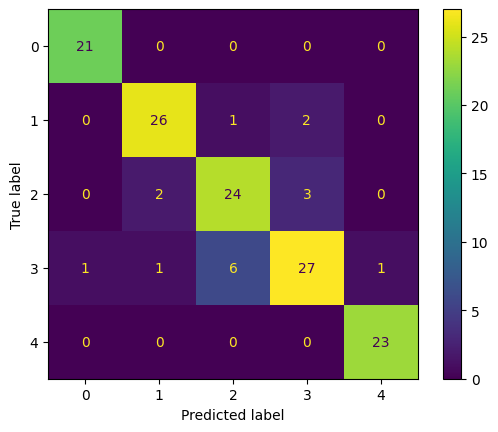

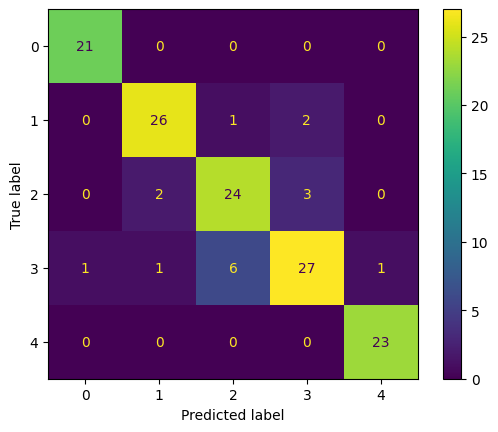

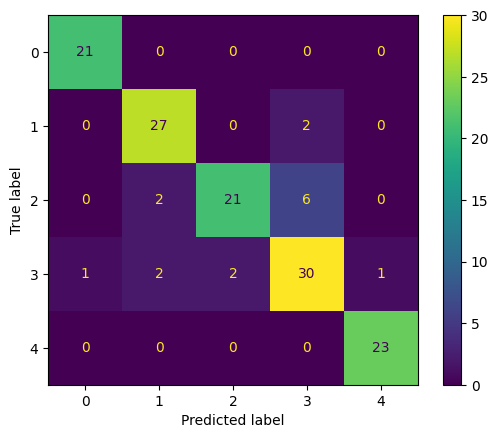

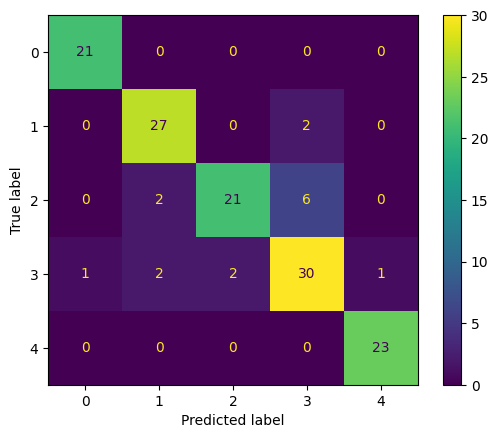

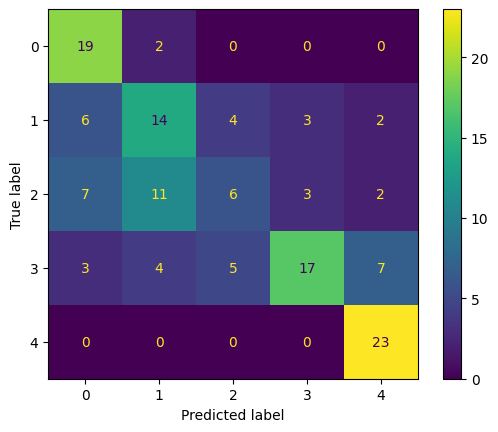

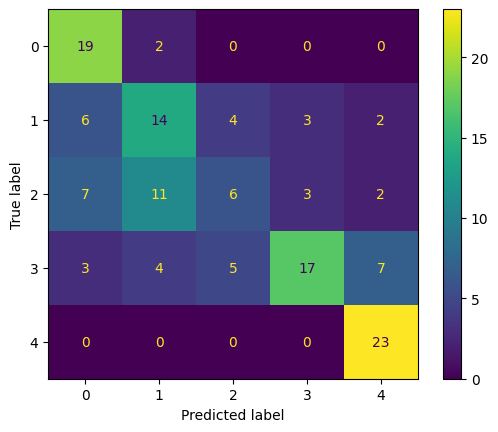

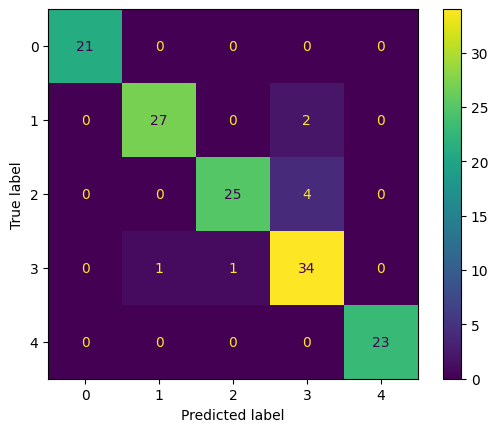

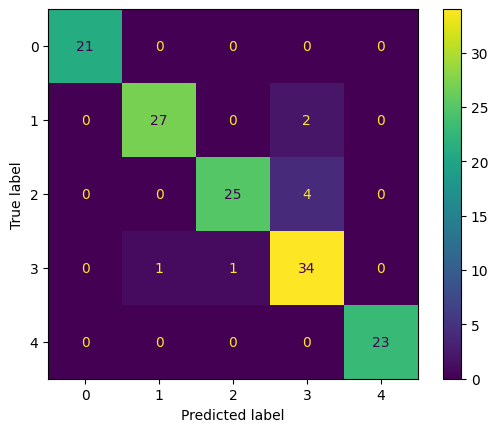

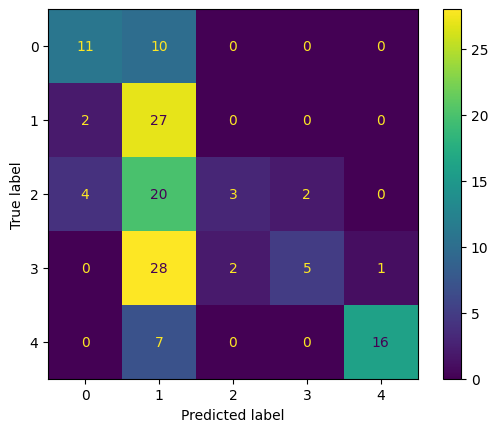

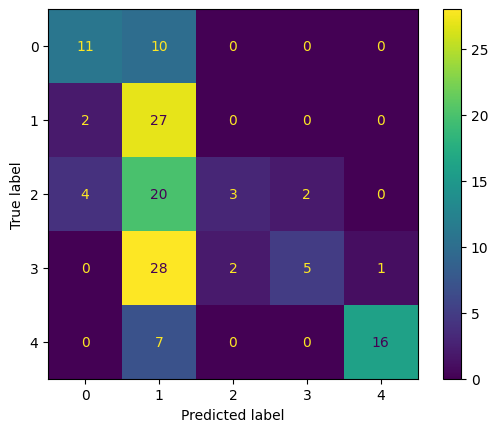

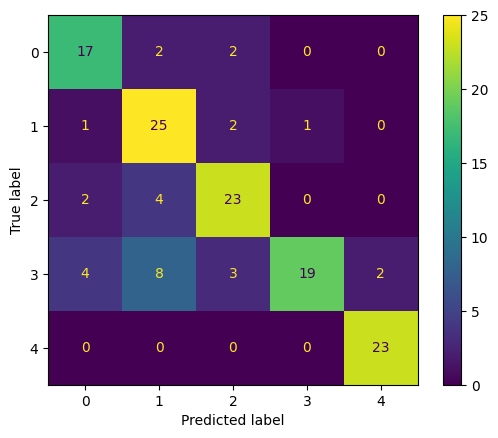

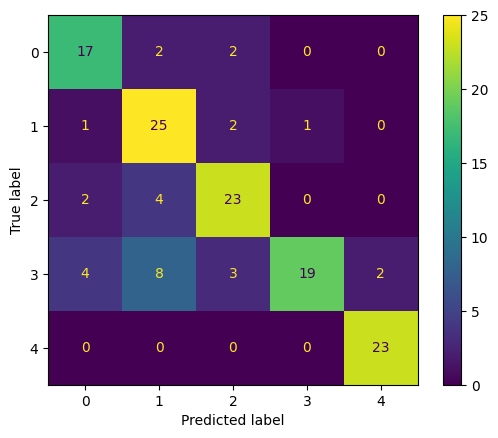

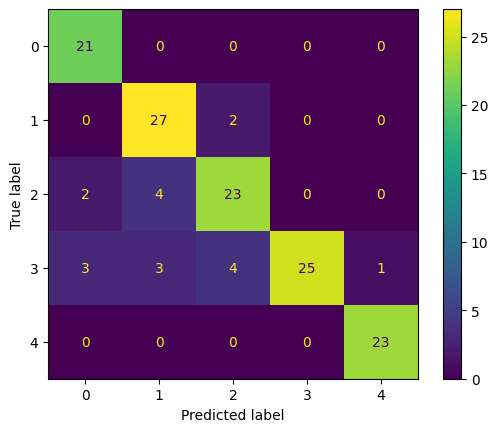

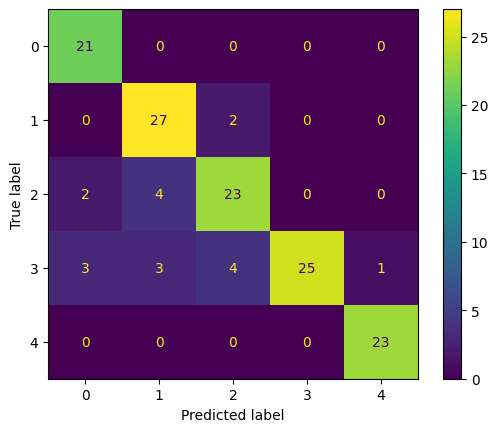

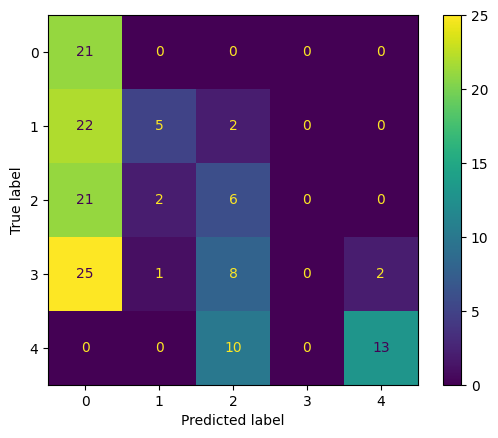

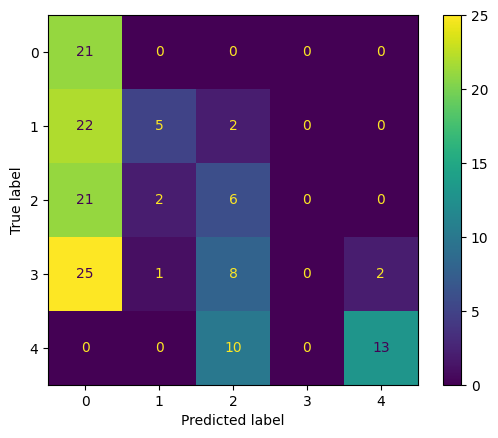

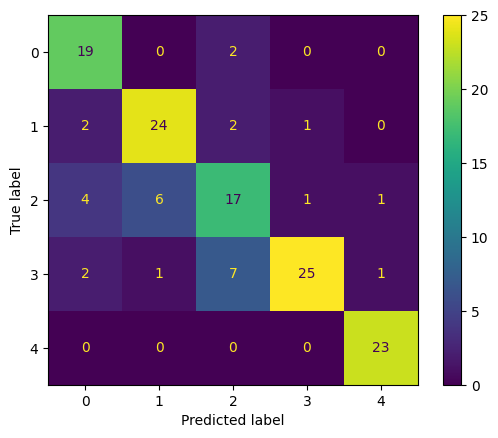

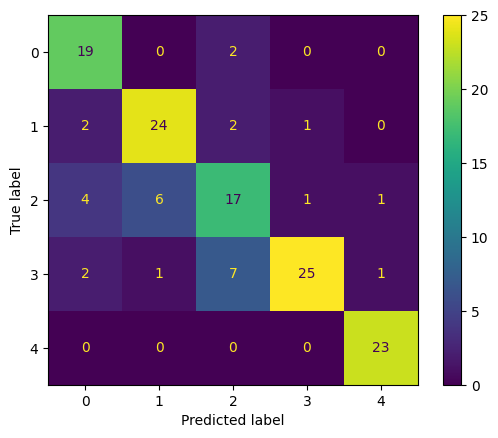

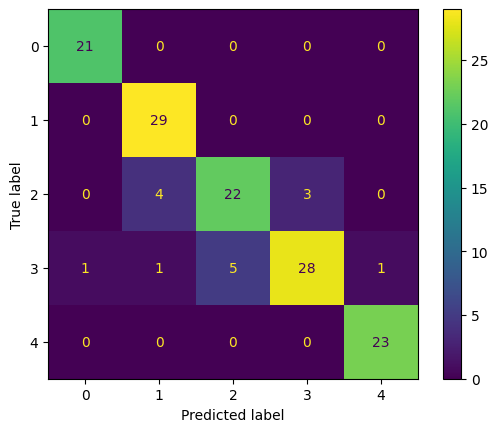

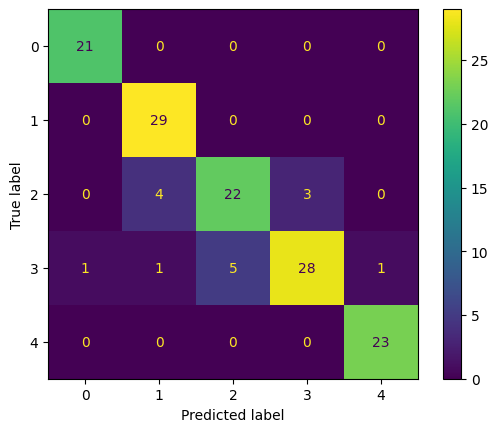

In [ ]:
# Assuming 'Potential_Accident_Level' is the column with string labels
label_mapping = {'I': 0, 'II': 1, 'III': 2, 'IV': 3, 'V': 4}
# Apply the mapping to both y_train and y_test
y_train_encoded = np.array([label_mapping[label] for label in y_train])
y_test_encoded = np.array([label_mapping[label] for label in y_test])

# Now use y_train_encoded and y_test_encoded in your ml_models function
combined_model_result = ml_models(X_train_tf.toarray(), y_train_encoded, X_test_tf.toarray(), y_test_encoded)

We got some satisfactory accuracy after building ML models based on TF-IDF vectorization database. The balanced train and test accuracy and F1 score is for SVM which has 100% train accuracy, 94% test accuracy and 94% F1 score.

In [ ]:
combined_model_result

Model  Train_accuracy  Test_accuracy  F1_score  Precision  \
0          LogReg        0.992754       0.876812  0.875438   0.876186   
1     Naive Bayes        1.000000       0.884058  0.882134   0.885830   
2             KNN        0.750000       0.572464  0.543475   0.567133   
3             SVM        1.000000       0.942029  0.942376   0.945282   
4   Decision Tree        0.585145       0.449275  0.412969   0.629424   
5    RandomForest        0.922101       0.775362  0.770077   0.804769   
6         Bagging        1.000000       0.862319  0.859724   0.877048   
7        AdaBoost        0.364130       0.326087  0.274784   0.360186   
8  Gradient Boost        0.958333       0.782609  0.780698   0.792245   
9         XGBoost        1.000000       0.891304  0.888376   0.891074   

     Recall  
0  0.876812  
1  0.884058  
2  0.572464  
3  0.942029  
4  0.449275  
5  0.775362  
6  0.862319  
7  0.326087  
8  0.782609  
9  0.891304

## **Milestone-2**

In [ ]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [ ]:
!pip install unidecode
!pip install autocorrect
!pip install google_trans_new
!pip install ann_visualizer
!pip install googletrans

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 28.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=834757a4fa82e64257eb01de0262b854a56ac188075a3db5e2ae4e1af5d4e000
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect
  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4169 sha256=684c26135834b05d83e89bff4d4f8497c74f7d4423aefda4c033bcc9eb9c385b
  Stored in directory: /root/.cache/pip/wheels/6e/0f/ae/f5dba91db71b1b32bf03d0ad18c32e86126093aba5ec6b6488
Successfully built ann_visualizer
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk import tokenize, stem
from tensorflow.keras.preprocessing.text import Tokenizer

import re
import string
from nltk.probability import FreqDist
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import unicodedata
import unidecode
from autocorrect import Speller
from string import punctuation
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical

from keras.callbacks import EarlyStopping, ModelCheckpoint

from google_trans_new import google_translator

from ann_visualizer.visualize import ann_viz
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, GRU, Dense
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Step 1: Design, train and test Neural networks classifiers

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 696ms/step - accuracy: 0.3711 - loss: 1.5907 - val_accuracy: 0.6216 - val_loss: 1.4864
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8197 - loss: 1.3150 - val_accuracy: 0.6757 - val_loss: 1.0169
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9031 - loss: 0.6840 - val_accuracy: 0.8468 - val_loss: 0.5152
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.1153 - val_accuracy: 0.8198 - val_loss: 0.4665
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0116 - val_accuracy: 0.8739 - val_loss: 0.4446
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.8378 - val_loss: 0.4787
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.8559 - val_loss: 0.4930
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.8209e-04 - val_accuracy: 0.8468 - va

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


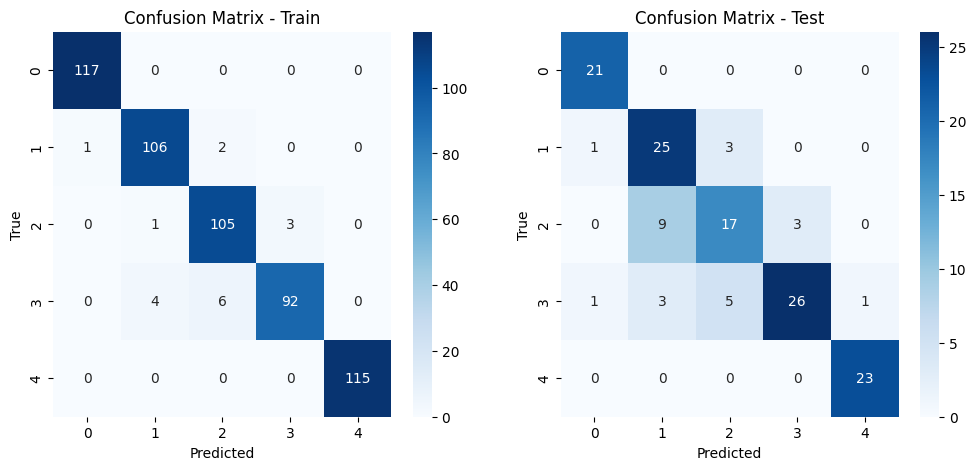

               Metric     Value
0  Train Accuracy_ANN  0.969203
1   Test Accuracy_ANN  0.811594
2        F1 Score_ANN  0.808587
3       Precision_ANN  0.817435
4          Recall_ANN  0.811594


In [ ]:
# @title Basic ANN

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Define ANN model
descriptions = final_database['Description_preprocess']
# Tokenization and preprocessing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(descriptions)  # `X_train_text` should be your list of texts for training

# Save tokenizer
with open('/content/drive/MyDrive/Capstone Project/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle)

# Reshape data for Bidirectional GRU
X_train_tf_reshaped = np.reshape(X_train_tf.toarray(), (X_train_tf.shape[0], 1, X_train_tf.shape[1]))
X_test_tf_reshaped = np.reshape(X_test_tf.toarray(), (X_test_tf.shape[0], 1, X_test_tf.shape[1]))

model_ANN = Sequential()
model_ANN.add(Input(shape=(X_train_tf.shape[1],)))  # Use the original shape of X_train_tf
model_ANN.add(Dense(512, activation='relu'))
model_ANN.add(Dense(128, activation='relu'))
model_ANN.add(Dense(64, activation='relu'))
model_ANN.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model_ANN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_ANN.fit(X_train_tf.toarray(), y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Save the model
model_ANN.save('/content/drive/MyDrive/Capstone Project/model_ANN.h5')

# Predictions
y_train_pred_prob = model_ANN.predict(X_train_tf.toarray())
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
y_test_pred_prob = model_ANN.predict(X_test_tf.toarray())
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# Confusion matrices
cm_train = confusion_matrix(y_train_encoded, y_train_pred)
cm_test = confusion_matrix(y_test_encoded, y_test_pred)

# Display confusion matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate metrics
train_accuracy_ANN = accuracy_score(y_train_encoded, y_train_pred)
test_accuracy_ANN = accuracy_score(y_test_encoded, y_test_pred)
f1_ANN = f1_score(y_test_encoded, y_test_pred, average='weighted')
precision_ANN = precision_score(y_test_encoded, y_test_pred, average='weighted')
recall_ANN = recall_score(y_test_encoded, y_test_pred, average='weighted')

# Display metrics
metrics_df = pd.DataFrame({
    'Metric': ['Train Accuracy_ANN', 'Test Accuracy_ANN', 'F1 Score_ANN', 'Precision_ANN', 'Recall_ANN'],
    'Value': [train_accuracy_ANN, test_accuracy_ANN, f1_ANN, precision_ANN, recall_ANN]
})
print(metrics_df)


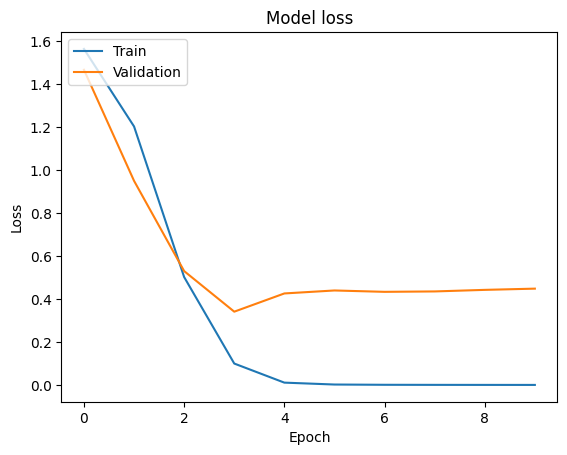

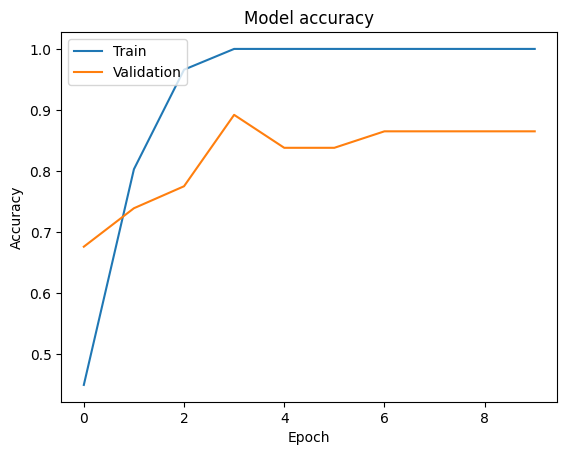

In [ ]:
#@title Plot training and validation loss and training and validation accuracy graph

import matplotlib.pyplot as plt
# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Step 2: Design, train and test RNN or LSTM classifiers

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3712 - loss: 1.5878 - val_accuracy: 0.6757 - val_loss: 1.4683
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8042 - loss: 1.3245 - val_accuracy: 0.7387 - val_loss: 0.9510
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9359 - loss: 0.6255 - val_accuracy: 0.7748 - val_loss: 0.5307
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.1403 - val_accuracy: 0.8919 - val_loss: 0.3418
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0163 - val_accuracy: 0.8378 - val_loss: 0.4266
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.8378 - val_loss: 0.4405
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8649 - val_loss: 0.4341
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.5181e-04 - val_accuracy: 0.8649 - val_l

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


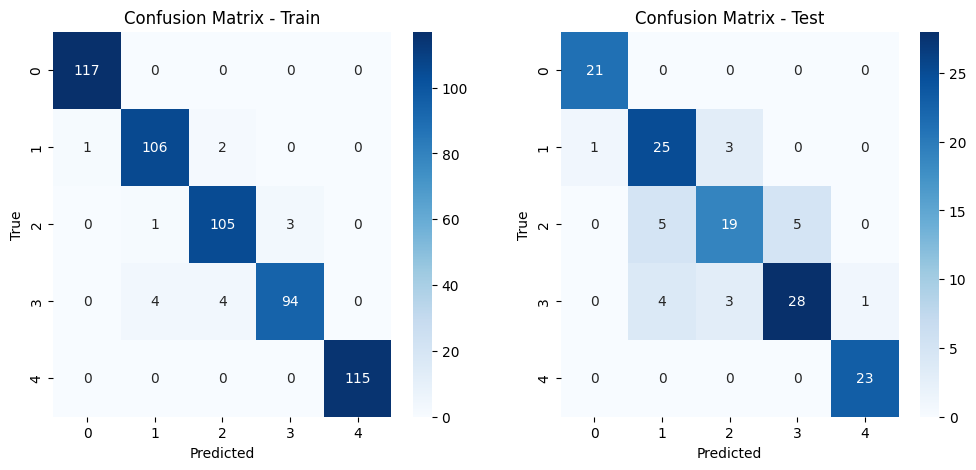

               Metric     Value
0  Train Accuracy_RNN  0.972826
1   Test Accuracy_RNN  0.840580
2        F1 Score_RNN  0.838137
3       Precision_RNN  0.840551
4          Recall_RNN  0.840580


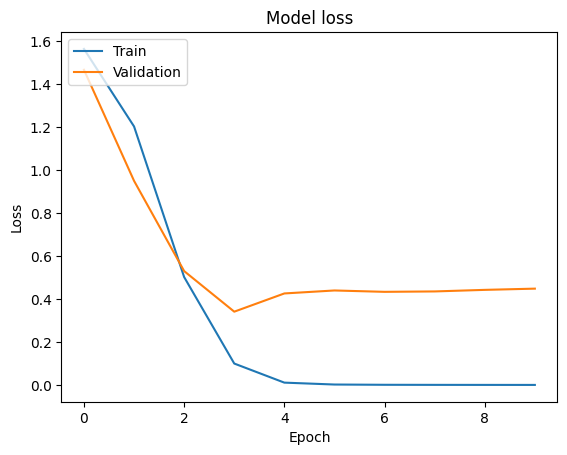

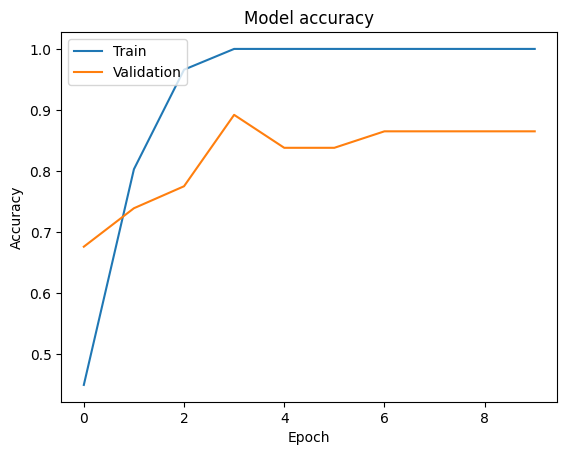

In [ ]:
#@title Basic RNN

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Define RNN model
model_RNN = Sequential()
model_RNN.add(Input(shape=(X_train_tf_reshaped.shape[1], X_train_tf_reshaped.shape[2])))
model_RNN.add(SimpleRNN(512, activation='relu', return_sequences=True))
model_RNN.add(SimpleRNN(128, activation='relu'))
model_RNN.add(Dense(64, activation='relu'))
model_RNN.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model_RNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_RNN.fit(X_train_tf_reshaped, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Save the model
model_RNN.save('/content/drive/MyDrive/Capstone Project/model_RNN.h5')

# Predictions
y_train_pred_prob = model_RNN.predict(X_train_tf_reshaped)
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
y_test_pred_prob = model_RNN.predict(X_test_tf_reshaped)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# Confusion matrices
cm_train = confusion_matrix(y_train_encoded, y_train_pred)
cm_test = confusion_matrix(y_test_encoded, y_test_pred)

# Display confusion matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate metrics
train_accuracy_RNN = accuracy_score(y_train_encoded, y_train_pred)
test_accuracy_RNN = accuracy_score(y_test_encoded, y_test_pred)
f1_RNN = f1_score(y_test_encoded, y_test_pred, average='weighted')
precision_RNN = precision_score(y_test_encoded, y_test_pred, average='weighted')
recall_RNN = recall_score(y_test_encoded, y_test_pred, average='weighted')

# Display metrics
metrics_df = pd.DataFrame({
    'Metric': ['Train Accuracy_RNN', 'Test Accuracy_RNN', 'F1 Score_RNN', 'Precision_RNN', 'Recall_RNN'],
    'Value': [train_accuracy_RNN, test_accuracy_RNN, f1_RNN, precision_RNN, recall_RNN]
})
print(metrics_df)

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 312ms/step - accuracy: 0.3724 - loss: 1.5693 - val_accuracy: 0.6126 - val_loss: 1.3273
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8499 - loss: 1.0256 - val_accuracy: 0.8378 - val_loss: 0.6235
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9969 - loss: 0.2429 - val_accuracy: 0.8378 - val_loss: 0.4116
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0086 - val_accuracy: 0.8739 - val_loss: 0.4420
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 8.0847e-04 - val_accuracy: 0.8649 - val_loss: 0.4917
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2015e-04 - val_accuracy: 0.8559 - val_loss: 0.5121
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.6933e-04 - val_accuracy: 0.8559 - val_loss: 0.5197
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 1.3141e-04 - val_accuracy:

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


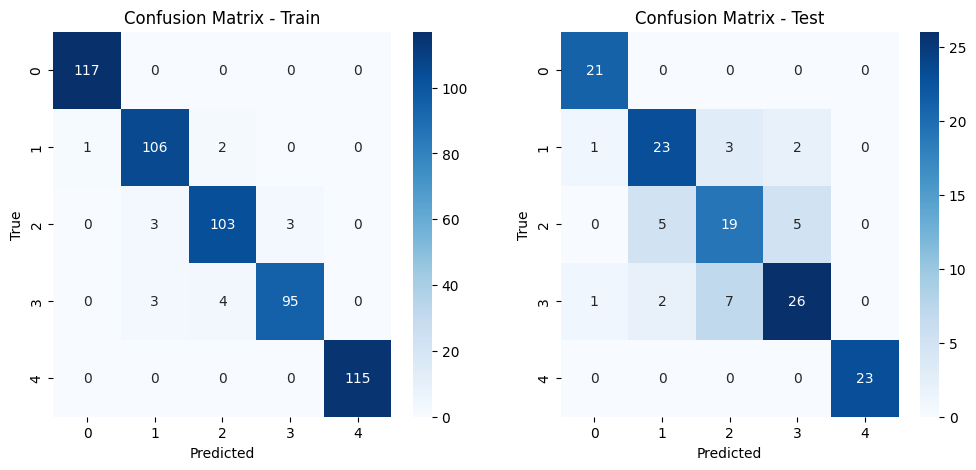

                 Metric     Value
0  Train Accuracy_BiRNN  0.971014
1   Test Accuracy_BiRNN  0.811594
2        F1 Score_BiRNN  0.810044
3       Precision_BiRNN  0.809934
4          Recall_BiRNN  0.811594


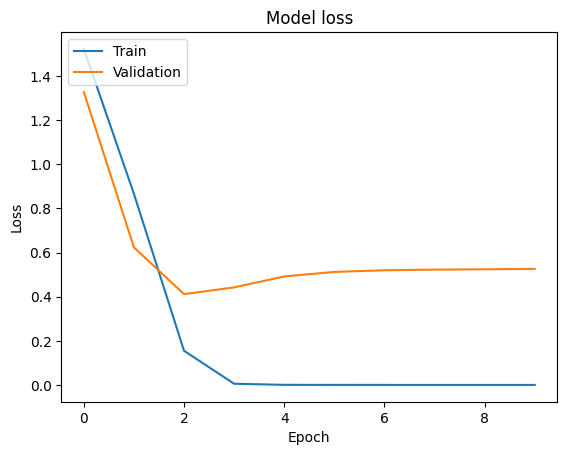

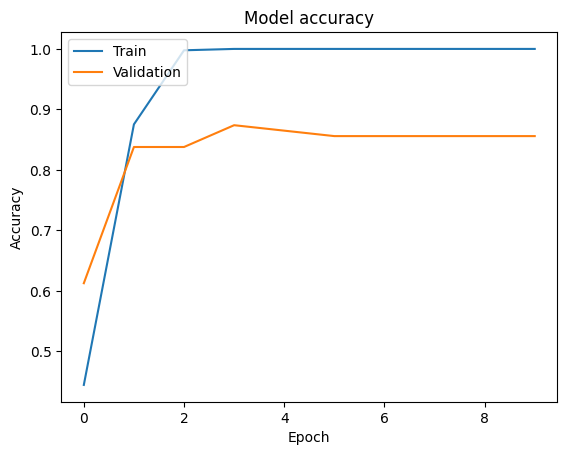

In [ ]:
#@title Bi-directional RNN

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Bidirectional, SimpleRNN, GRU, LSTM, Dense

# Define Bi-directional RNN model
model_BiRNN = Sequential()
model_BiRNN.add(Input(shape=(X_train_tf_reshaped.shape[1], X_train_tf_reshaped.shape[2])))
model_BiRNN.add(Bidirectional(SimpleRNN(512, activation='relu', return_sequences=True)))
model_BiRNN.add(Bidirectional(SimpleRNN(128, activation='relu')))
model_BiRNN.add(Dense(64, activation='relu'))
model_BiRNN.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model_BiRNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_BiRNN.fit(X_train_tf_reshaped, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Save the model
model_BiRNN.save('/content/drive/MyDrive/Capstone Project/model_BiRNN.h5')

# Predictions
y_train_pred_prob = model_BiRNN.predict(X_train_tf_reshaped)
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
y_test_pred_prob = model_BiRNN.predict(X_test_tf_reshaped)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# Confusion matrices
cm_train = confusion_matrix(y_train_encoded, y_train_pred)
cm_test = confusion_matrix(y_test_encoded, y_test_pred)

# Display confusion matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate metrics
train_accuracy_BiRNN = accuracy_score(y_train_encoded, y_train_pred)
test_accuracy_BiRNN = accuracy_score(y_test_encoded, y_test_pred)
f1_BiRNN = f1_score(y_test_encoded, y_test_pred, average='weighted')
precision_BiRNN = precision_score(y_test_encoded, y_test_pred, average='weighted')
recall_BiRNN = recall_score(y_test_encoded, y_test_pred, average='weighted')

# Display metrics
metrics_df = pd.DataFrame({
    'Metric': ['Train Accuracy_BiRNN', 'Test Accuracy_BiRNN', 'F1 Score_BiRNN', 'Precision_BiRNN', 'Recall_BiRNN'],
    'Value': [train_accuracy_BiRNN, test_accuracy_BiRNN, f1_BiRNN, precision_BiRNN, recall_BiRNN]
})
print(metrics_df)

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 988ms/step - accuracy: 0.2365 - loss: 1.6085 - val_accuracy: 0.4324 - val_loss: 1.6032
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5098 - loss: 1.5913 - val_accuracy: 0.5405 - val_loss: 1.5562
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6319 - loss: 1.4929 - val_accuracy: 0.5405 - val_loss: 1.3196
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6472 - loss: 1.0867 - val_accuracy: 0.5856 - val_loss: 0.8204
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8284 - loss: 0.5184 - val_accuracy: 0.8919 - val_loss: 0.4541
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9964 - loss: 0.1080 - val_accuracy: 0.8919 - val_loss: 0.3358
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0097 - val_accuracy: 0.8919 - val_loss: 0.3777
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.8649 - val_lo

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


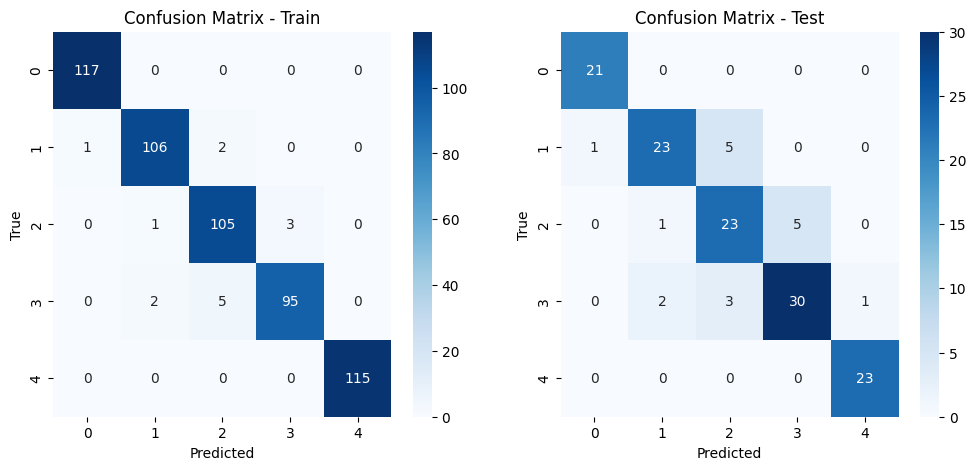

                Metric     Value
0  Train Accuracy_LSTM  0.974638
1   Test Accuracy_LSTM  0.869565
2        F1 Score_LSTM  0.869077
3       Precision_LSTM  0.870393
4          Recall_LSTM  0.869565


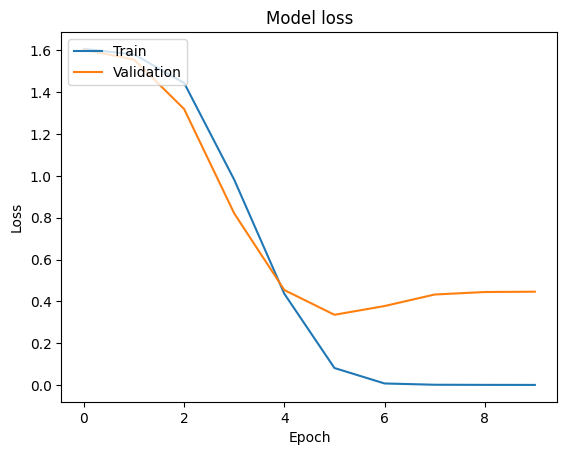

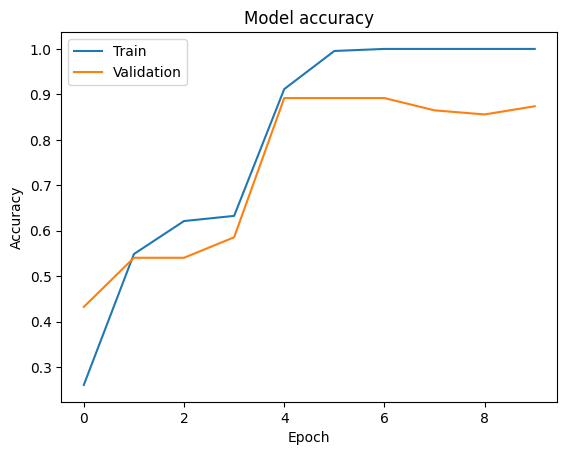

In [ ]:
# @title LSTM

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Define LSTM model
model_LSTM = Sequential()
model_LSTM.add(Input(shape=(X_train_tf_reshaped.shape[1], X_train_tf_reshaped.shape[2])))
model_LSTM.add(LSTM(512, activation='relu', return_sequences=True))
model_LSTM.add(LSTM(128, activation='relu'))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model_LSTM.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_LSTM.fit(X_train_tf_reshaped, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Save the model
model_LSTM.save('/content/drive/MyDrive/Capstone Project/model_LSTM.h5')

# Predictions
y_train_pred_prob = model_LSTM.predict(X_train_tf_reshaped)
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
y_test_pred_prob = model_LSTM.predict(X_test_tf_reshaped)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# Confusion matrices
cm_train = confusion_matrix(y_train_encoded, y_train_pred)
cm_test = confusion_matrix(y_test_encoded, y_test_pred)

# Display confusion matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate metrics
train_accuracy_LSTM = accuracy_score(y_train_encoded, y_train_pred)
test_accuracy_LSTM = accuracy_score(y_test_encoded, y_test_pred)
f1_LSTM = f1_score(y_test_encoded, y_test_pred, average='weighted')
precision_LSTM = precision_score(y_test_encoded, y_test_pred, average='weighted')
recall_LSTM = recall_score(y_test_encoded, y_test_pred, average='weighted')

# Display metrics
metrics_df = pd.DataFrame({
    'Metric': ['Train Accuracy_LSTM', 'Test Accuracy_LSTM', 'F1 Score_LSTM', 'Precision_LSTM', 'Recall_LSTM'],
    'Value': [train_accuracy_LSTM, test_accuracy_LSTM, f1_LSTM, precision_LSTM, recall_LSTM]
})
print(metrics_df)

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 341ms/step - accuracy: 0.2532 - loss: 1.6078 - val_accuracy: 0.4955 - val_loss: 1.5930
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6364 - loss: 1.5659 - val_accuracy: 0.5495 - val_loss: 1.4562
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6747 - loss: 1.2973 - val_accuracy: 0.6306 - val_loss: 0.9735
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8015 - loss: 0.6255 - val_accuracy: 0.7568 - val_loss: 0.5400
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.1508 - val_accuracy: 0.8198 - val_loss: 0.4295
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0118 - val_accuracy: 0.9009 - val_loss: 0.4987
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.8919 - val_loss: 0.5376
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 3.0104e-04 - val_accuracy: 0.8919 - va

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


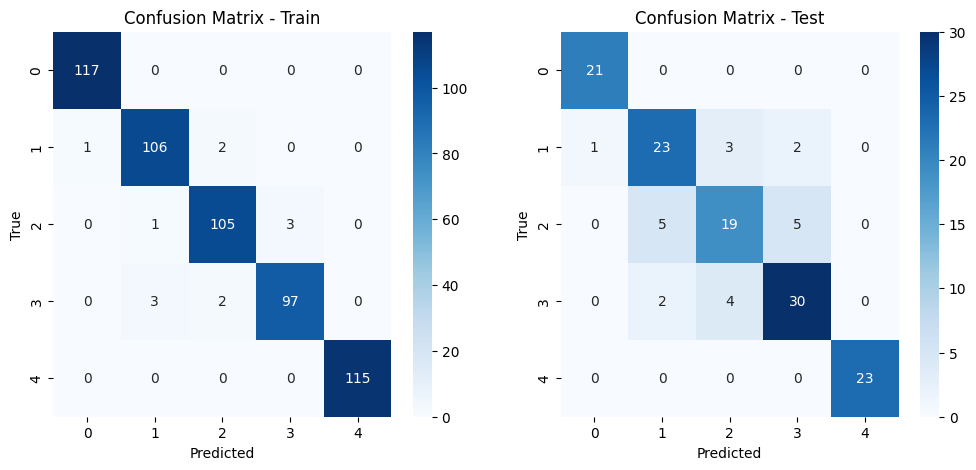

                  Metric     Value
0  Train Accuracy_BiLSTM  0.978261
1   Test Accuracy_BiLSTM  0.840580
2        F1 Score_BiLSTM  0.838748
3       Precision_BiLSTM  0.838118
4          Recall_BiLSTM  0.840580


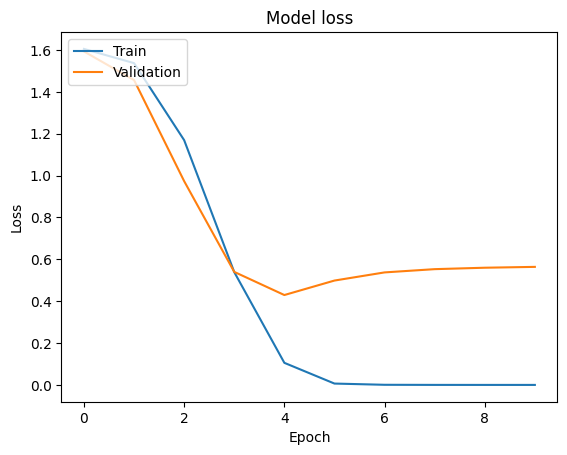

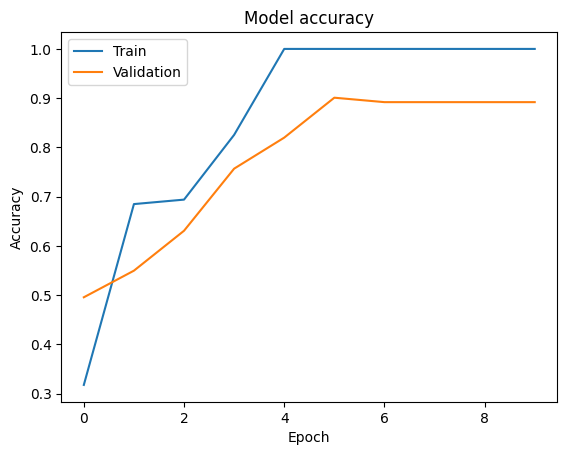

In [ ]:
# @title Generate Bi-directional LSTM classifier

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Bidirectional, LSTM, SimpleRNN, GRU, Dense

# Define Bi-directional LSTM model
model_BiLSTM = Sequential()
model_BiLSTM.add(Input(shape=(X_train_tf_reshaped.shape[1], X_train_tf_reshaped.shape[2])))
model_BiLSTM.add(Bidirectional(LSTM(512, activation='relu', return_sequences=True)))
model_BiLSTM.add(Bidirectional(LSTM(128, activation='relu')))
model_BiLSTM.add(Dense(64, activation='relu'))
model_BiLSTM.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model_BiLSTM.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_BiLSTM.fit(X_train_tf_reshaped, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Save the model
model_BiLSTM.save('/content/drive/MyDrive/Capstone Project/model_BiLSTM.h5')

# Predictions
y_train_pred_prob = model_BiLSTM.predict(X_train_tf_reshaped)
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
y_test_pred_prob = model_BiLSTM.predict(X_test_tf_reshaped)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# Confusion matrices
cm_train = confusion_matrix(y_train_encoded, y_train_pred)
cm_test = confusion_matrix(y_test_encoded, y_test_pred)

# Display confusion matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate metrics
train_accuracy_BiLSTM = accuracy_score(y_train_encoded, y_train_pred)
test_accuracy_BiLSTM = accuracy_score(y_test_encoded, y_test_pred)
f1_BiLSTM = f1_score(y_test_encoded, y_test_pred, average='weighted')
precision_BiLSTM = precision_score(y_test_encoded, y_test_pred, average='weighted')
recall_BiLSTM = recall_score(y_test_encoded, y_test_pred, average='weighted')

# Display metrics
metrics_df = pd.DataFrame({
    'Metric': ['Train Accuracy_BiLSTM', 'Test Accuracy_BiLSTM', 'F1 Score_BiLSTM', 'Precision_BiLSTM', 'Recall_BiLSTM'],
    'Value': [train_accuracy_BiLSTM, test_accuracy_BiLSTM, f1_BiLSTM, precision_BiLSTM, recall_BiLSTM]
})
print(metrics_df)

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.2391 - loss: 1.5970 - val_accuracy: 0.6216 - val_loss: 1.4860
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8137 - loss: 1.3044 - val_accuracy: 0.6216 - val_loss: 0.9121
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8805 - loss: 0.6082 - val_accuracy: 0.8288 - val_loss: 0.5313
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 0.2084 - val_accuracy: 0.8559 - val_loss: 0.3711
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0260 - val_accuracy: 0.8739 - val_loss: 0.3847
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 0.8649 - val_loss: 0.4113
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.8649 - val_loss: 0.4245
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.8649 - v

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


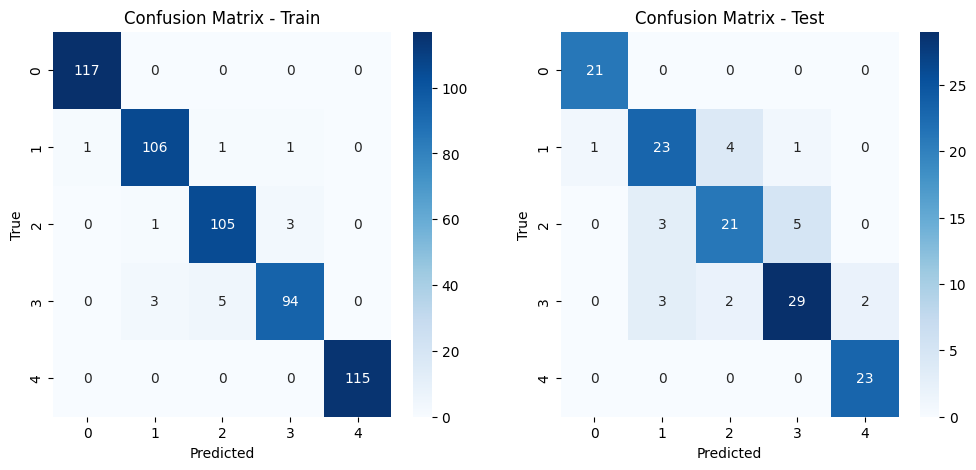

                  Metric     Value
0  Train Accuracy_BiLSTM  0.972826
1   Test Accuracy_BiLSTM  0.847826
2        F1 Score_BiLSTM  0.845737
3       Precision_BiLSTM  0.844852
4          Recall_BiLSTM  0.847826


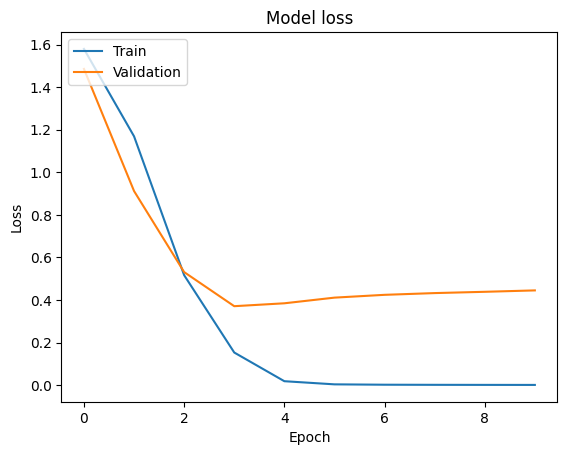

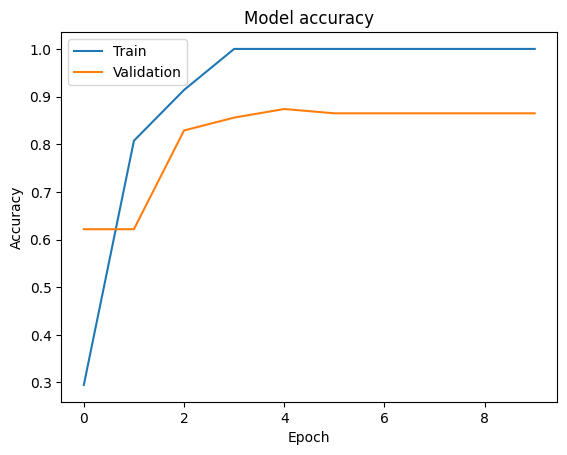

In [ ]:
# @title Birectional LSTM with tanh

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Bidirectional, LSTM, SimpleRNN, GRU, Dense

# Define Bi-directional LSTM model
model_BiLSTM = Sequential()
model_BiLSTM.add(Input(shape=(X_train_tf_reshaped.shape[1], X_train_tf_reshaped.shape[2])))
model_BiLSTM.add(Bidirectional(LSTM(512, activation='tanh', return_sequences=True))) # Changed 'tenh' to 'tanh'
model_BiLSTM.add(Bidirectional(LSTM(128, activation='tanh'))) # Changed 'tenh' to 'tanh'
model_BiLSTM.add(Dense(64, activation='tanh')) # Changed 'tenh' to 'tanh'
model_BiLSTM.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model_BiLSTM.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_BiLSTM.fit(X_train_tf_reshaped, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Save the model
model_BiLSTM.save('/content/drive/MyDrive/Capstone Project/model_BiLSTM.h5')

# Predictions
y_train_pred_prob = model_BiLSTM.predict(X_train_tf_reshaped)
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
y_test_pred_prob = model_BiLSTM.predict(X_test_tf_reshaped)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# Confusion matrices
cm_train = confusion_matrix(y_train_encoded, y_train_pred)
cm_test = confusion_matrix(y_test_encoded, y_test_pred)

# Display confusion matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate metrics
train_accuracy_BiLSTM = accuracy_score(y_train_encoded, y_train_pred)
test_accuracy_BiLSTM = accuracy_score(y_test_encoded, y_test_pred)
f1_BiLSTM = f1_score(y_test_encoded, y_test_pred, average='weighted')
precision_BiLSTM = precision_score(y_test_encoded, y_test_pred, average='weighted')
recall_BiLSTM = recall_score(y_test_encoded, y_test_pred, average='weighted')

# Display metrics
metrics_df = pd.DataFrame({
    'Metric': ['Train Accuracy_BiLSTM', 'Test Accuracy_BiLSTM', 'F1 Score_BiLSTM', 'Precision_BiLSTM', 'Recall_BiLSTM'],
    'Value': [train_accuracy_BiLSTM, test_accuracy_BiLSTM, f1_BiLSTM, precision_BiLSTM, recall_BiLSTM]
})
print(metrics_df)

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 441ms/step - accuracy: 0.2604 - loss: 1.5989 - val_accuracy: 0.4865 - val_loss: 1.5141
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6705 - loss: 1.3859 - val_accuracy: 0.7117 - val_loss: 0.9812
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9616 - loss: 0.6395 - val_accuracy: 0.8288 - val_loss: 0.4677
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9969 - loss: 0.0590 - val_accuracy: 0.8919 - val_loss: 0.4002
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.8468 - val_loss: 0.5173
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.8646e-04 - val_accuracy: 0.8649 - val_loss: 0.5213
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 2.9019e-04 - val_accuracy: 0.8649 - val_loss: 0.5235
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0542e-04 - val_accuracy: 0.8

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


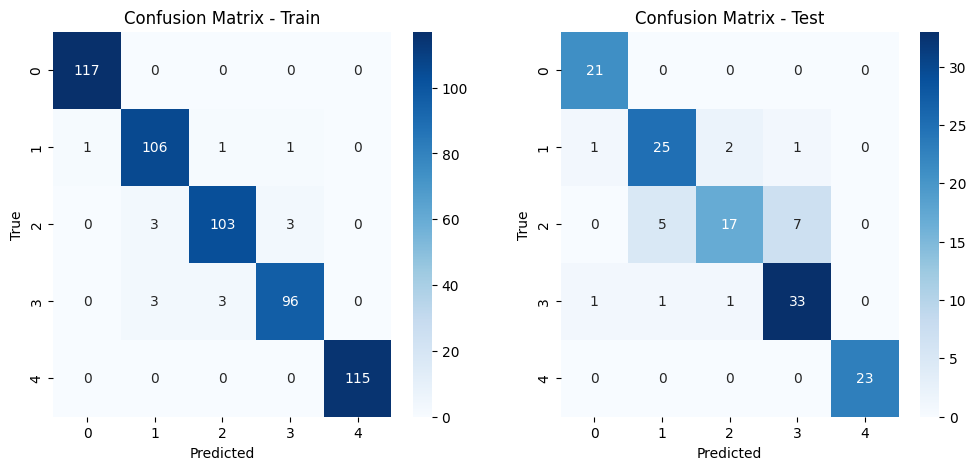

                 Metric     Value
0  Train Accuracy_BiGRU  0.972826
1   Test Accuracy_BiGRU  0.862319
2        F1 Score_BiGRU  0.856462
3       Precision_BiGRU  0.863671
4          Recall_BiGRU  0.862319


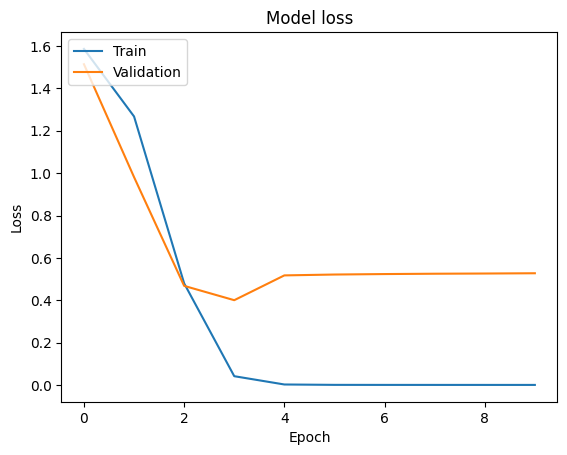

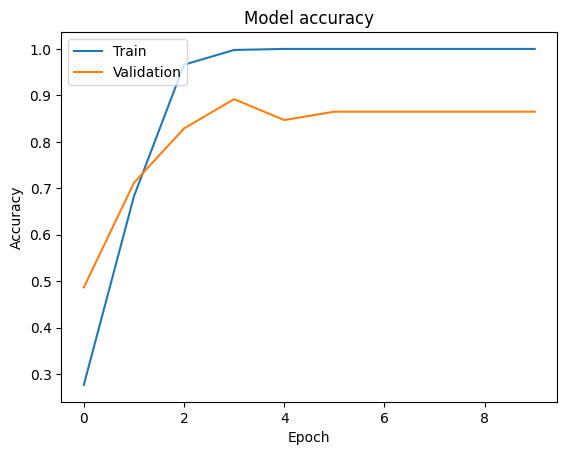

In [ ]:
# @title Generate Bi-directional GRU

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# @title GRU
# Define Bi-directional GRU model
model_BiGRU = Sequential()
model_BiGRU.add(Input(shape=(X_train_tf_reshaped.shape[1], X_train_tf_reshaped.shape[2])))
model_BiGRU.add(Bidirectional(GRU(512, activation='relu', return_sequences=True)))
model_BiGRU.add(Bidirectional(GRU(128, activation='relu')))
model_BiGRU.add(Dense(64, activation='relu'))
model_BiGRU.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model_BiGRU.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_BiGRU.fit(X_train_tf_reshaped, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Save the model
model_BiGRU.save('/content/drive/MyDrive/Capstone Project/model_BiGRU.h5')

# Predictions
y_train_pred_prob = model_BiGRU.predict(X_train_tf_reshaped)
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
y_test_pred_prob = model_BiGRU.predict(X_test_tf_reshaped)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# Confusion matrices
cm_train = confusion_matrix(y_train_encoded, y_train_pred)
cm_test = confusion_matrix(y_test_encoded, y_test_pred)

# Display confusion matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate metrics
train_accuracy_BiGRU = accuracy_score(y_train_encoded, y_train_pred)
test_accuracy_BiGRU = accuracy_score(y_test_encoded, y_test_pred)
f1_BiGRU = f1_score(y_test_encoded, y_test_pred, average='weighted')
precision_BiGRU = precision_score(y_test_encoded, y_test_pred, average='weighted')
recall_BiGRU = recall_score(y_test_encoded, y_test_pred, average='weighted')

# Display metrics
metrics_df = pd.DataFrame({
    'Metric': ['Train Accuracy_BiGRU', 'Test Accuracy_BiGRU', 'F1 Score_BiGRU', 'Precision_BiGRU', 'Recall_BiGRU'],
    'Value': [train_accuracy_BiGRU, test_accuracy_BiGRU, f1_BiGRU, precision_BiGRU, recall_BiGRU]
})
print(metrics_df)

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 483ms/step - accuracy: 0.3736 - loss: 1.5971 - val_accuracy: 0.6667 - val_loss: 1.5102
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8394 - loss: 1.3592 - val_accuracy: 0.6847 - val_loss: 0.9281
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9417 - loss: 0.6086 - val_accuracy: 0.7928 - val_loss: 0.4930
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9939 - loss: 0.0870 - val_accuracy: 0.8649 - val_loss: 0.3579
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.9009 - val_loss: 0.3812
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 8.3133e-04 - val_accuracy: 0.8919 - val_loss: 0.4225
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 2.9661e-04 - val_accuracy: 0.8919 - val_loss: 0.4429
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 2.3825e-04 - val_accuracy: 

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


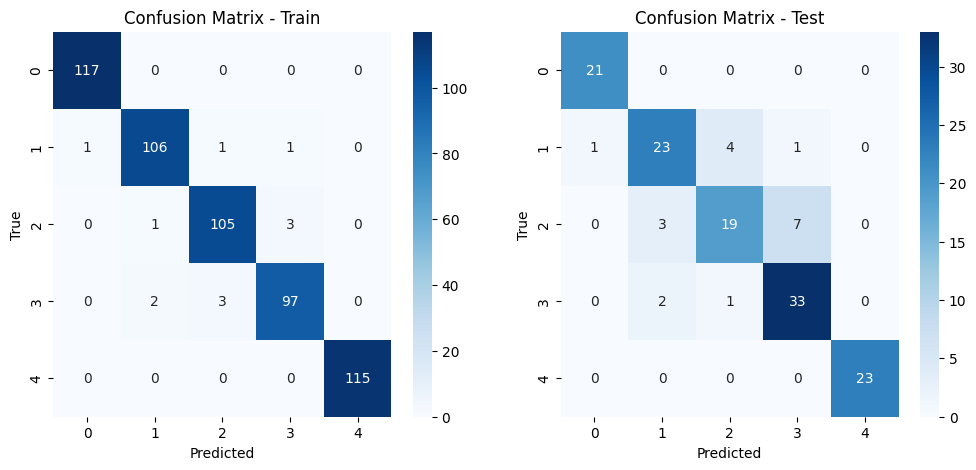

                 Metric     Value
0  Train Accuracy_BiGRU  0.978261
1   Test Accuracy_BiGRU  0.862319
2        F1 Score_BiGRU  0.859165
3       Precision_BiGRU  0.860876
4          Recall_BiGRU  0.862319


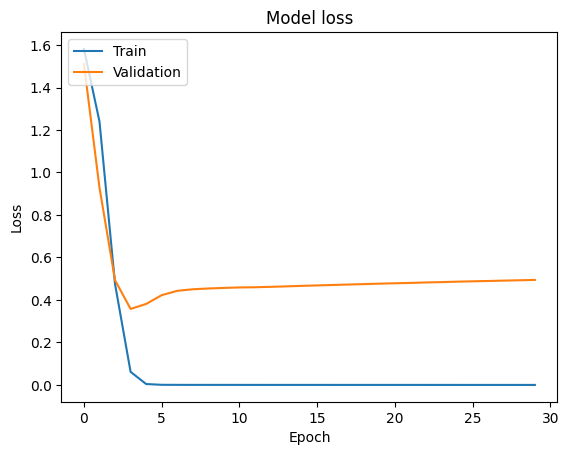

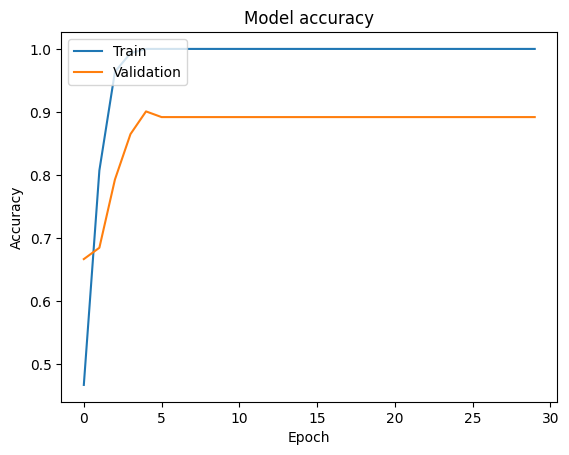

In [ ]:
# @title Bi-directional GRU with 30 epochs

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define Bi-directional GRU model
model_BiGRU = Sequential()
model_BiGRU.add(Input(shape=(X_train_tf_reshaped.shape[1], X_train_tf_reshaped.shape[2])))
model_BiGRU.add(Bidirectional(GRU(512, activation='relu', return_sequences=True)))
model_BiGRU.add(Bidirectional(GRU(128, activation='relu')))
model_BiGRU.add(Dense(64, activation='relu'))
model_BiGRU.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model_BiGRU.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_BiGRU.fit(X_train_tf_reshaped, y_train_encoded, epochs=30, batch_size=32, validation_split=0.2)

# Save the model
model_BiGRU.save('/content/drive/MyDrive/Capstone Project/model_BiGRU.h5')

# Predictions
y_train_pred_prob = model_BiGRU.predict(X_train_tf_reshaped)
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
y_test_pred_prob = model_BiGRU.predict(X_test_tf_reshaped)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# Confusion matrices
cm_train = confusion_matrix(y_train_encoded, y_train_pred)
cm_test = confusion_matrix(y_test_encoded, y_test_pred)

# Display confusion matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Train')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate metrics
train_accuracy_BiGRU = accuracy_score(y_train_encoded, y_train_pred)
test_accuracy_BiGRU = accuracy_score(y_test_encoded, y_test_pred)
f1_BiGRU = f1_score(y_test_encoded, y_test_pred, average='weighted')
precision_BiGRU = precision_score(y_test_encoded, y_test_pred, average='weighted')
recall_BiGRU = recall_score(y_test_encoded, y_test_pred, average='weighted')

# Display metrics
metrics_df = pd.DataFrame({
    'Metric': ['Train Accuracy_BiGRU', 'Test Accuracy_BiGRU', 'F1 Score_BiGRU', 'Precision_BiGRU', 'Recall_BiGRU'],
    'Value': [train_accuracy_BiGRU, test_accuracy_BiGRU, f1_BiGRU, precision_BiGRU, recall_BiGRU]
})
print(metrics_df)

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


         Train Accuracy  Test Accuracy  F1 Score  Precision    Recall
ANN            0.971014       0.818841  0.815840   0.818961  0.818841
RNN            0.963768       0.804348  0.800344   0.801142  0.804348
LSTM           0.978261       0.855072  0.852422   0.853446  0.855072
Bi-RNN         0.972826       0.840580  0.836723   0.842552  0.840580
Bi-LSTM        0.972826       0.847826  0.845737   0.844852  0.847826
Bi-GRU         0.978261       0.862319  0.859165   0.860876  0.862319


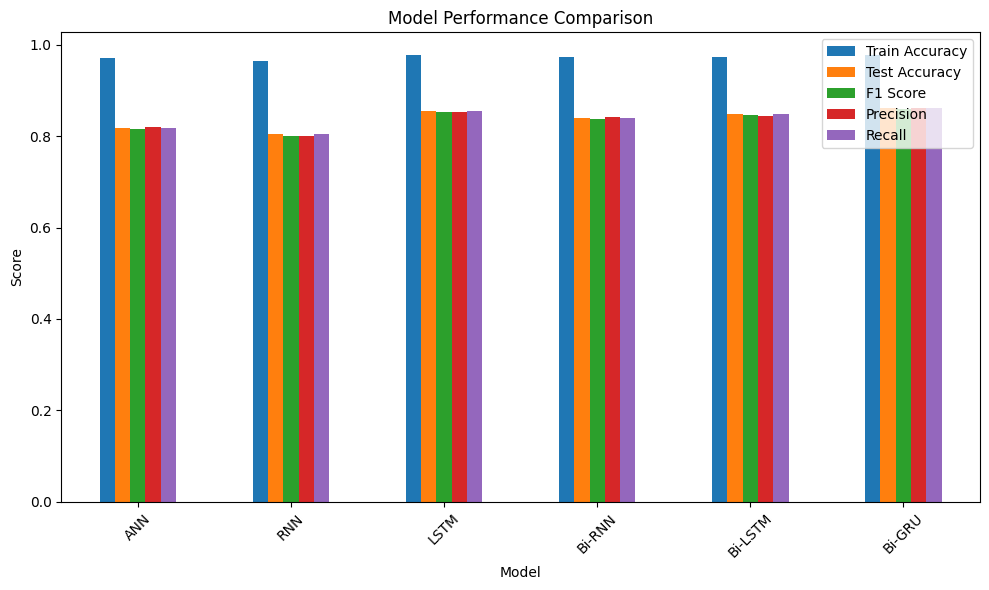

In [ ]:
# @title generate a consolidated report for all the above models

import pandas as pd
import matplotlib.pyplot as plt
# Assuming you have the following variables defined from your previous code:
# train_accuracy_ANN, test_accuracy_ANN, f1_ANN, ... (for ANN)
# train_accuracy_RNN, test_accuracy_RNN, f1_RNN, ... (for RNN)
# ... and so on for other models

# Create a dictionary to store the metrics
metrics_data = {
    'ANN': [train_accuracy_ANN, test_accuracy_ANN, f1_ANN, precision_ANN, recall_ANN],
    'RNN': [train_accuracy_RNN, test_accuracy_RNN, f1_RNN, precision_RNN, recall_RNN],
    'LSTM': [train_accuracy_LSTM, test_accuracy_LSTM, f1_LSTM, precision_LSTM, recall_LSTM],
    'Bi-RNN': [train_accuracy_BiRNN, test_accuracy_BiRNN, f1_BiRNN, precision_BiRNN, recall_BiRNN],
    'Bi-LSTM': [train_accuracy_BiLSTM, test_accuracy_BiLSTM, f1_BiLSTM, precision_BiLSTM, recall_BiLSTM],
    'Bi-GRU': [train_accuracy_BiGRU, test_accuracy_BiGRU, f1_BiGRU, precision_BiGRU, recall_BiGRU]
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame.from_dict(metrics_data, orient='index',
                                   columns=['Train Accuracy', 'Test Accuracy', 'F1 Score', 'Precision', 'Recall'])

# Display the DataFrame
print(metrics_df)

# Optional: Add a bar chart for visualization
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


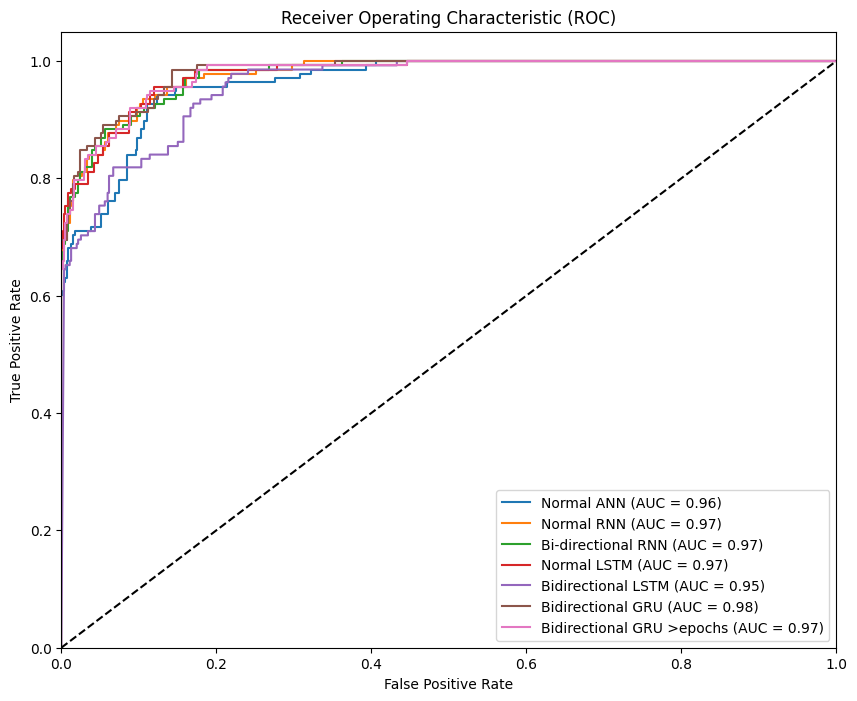

In [ ]:
# @title Generate ROC AUC graph for all the models

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels
y_test_binarized = label_binarize(y_test_encoded, classes=np.unique(y_test_encoded))

# Calculate ROC curves and AUC scores for each model
plt.figure(figsize=(10, 8))

# Add a batch dimension to X_test_tf_reshaped
X_test_tf_reshaped_with_batch = np.expand_dims(X_test_tf_reshaped, axis=0)

# Normal ANN
y_test_pred_prob_ann = model_ANN.predict(X_test_tf_reshaped.reshape(X_test_tf_reshaped.shape[0], -1)) # Reshape the input to remove the extra dimension
roc_auc_ann = roc_auc_score(y_test_encoded, y_test_pred_prob_ann, multi_class='ovr')
fpr_ann, tpr_ann, _ = roc_curve(y_test_binarized.ravel(), y_test_pred_prob_ann.ravel())
plt.plot(fpr_ann, tpr_ann, label='Normal ANN (AUC = %0.2f)' % roc_auc_ann)

# Normal RNN
fpr_RNN, tpr_RNN, _ = roc_curve(y_test_binarized.ravel(), y_test_pred_prob_RNN.ravel())
plt.plot(fpr_RNN, tpr_RNN, label='Normal RNN (AUC = %0.2f)' % roc_auc_RNN)

# Bi-directional RNN
y_test_pred_prob_BiRNN = model_BiRNN.predict(X_test_tf_reshaped)
roc_auc_BiRNN = roc_auc_score(y_test_encoded, y_test_pred_prob_BiRNN, multi_class='ovr')
fpr_BiRNN, tpr_BiRNN, _ = roc_curve(y_test_binarized.ravel(), y_test_pred_prob_BiRNN.ravel())
plt.plot(fpr_BiRNN, tpr_BiRNN, label='Bi-directional RNN (AUC = %0.2f)' % roc_auc_BiRNN)

# Normal LSTM
fpr_LSTM, tpr_LSTM, _ = roc_curve(y_test_binarized.ravel(), y_test_pred_prob_LSTM.ravel())
plt.plot(fpr_LSTM, tpr_LSTM, label='Normal LSTM (AUC = %0.2f)' % roc_auc_LSTM)

# Bidirectional LSTM
y_test_pred_prob_BiLSTM = model_BiLSTM.predict(X_test_tf_reshaped)
roc_auc_BiLSTM = roc_auc_score(y_test_encoded, y_test_pred_prob_BiLSTM, multi_class='ovr')
fpr_BiLSTM, tpr_BiLSTM, _ = roc_curve(y_test_binarized.ravel(), y_test_pred_prob_BiLSTM.ravel())
plt.plot(fpr_BiLSTM, tpr_BiLSTM, label='Bidirectional LSTM (AUC = %0.2f)' % roc_auc_BiLSTM)

# Bidirectional GRU
y_test_pred_prob_BiGRU = model_BiGRU.predict(X_test_tf_reshaped)
roc_auc_BiGRU = roc_auc_score(y_test_encoded, y_test_pred_prob_BiGRU, multi_class='ovr')
fpr_BiGRU, tpr_BiGRU, _ = roc_curve(y_test_binarized.ravel(), y_test_pred_prob_BiGRU.ravel())
plt.plot(fpr_BiGRU, tpr_BiGRU, label='Bidirectional GRU (AUC = %0.2f)' % roc_auc_BiGRU)

# Bidirectional GRU with increased epochs
y_test_pred_prob_BiGRUepoch = model_BiGRUepoch.predict(X_test_tf_reshaped)
roc_auc_BiGRUepoch = roc_auc_score(y_test_encoded, y_test_pred_prob_BiGRUepoch, multi_class='ovr')
fpr_BiGRUepoch, tpr_BiGRUepoch, _ = roc_curve(y_test_binarized.ravel(), y_test_pred_prob_BiGRUepoch.ravel())
plt.plot(fpr_BiGRUepoch, tpr_BiGRUepoch, label='Bidirectional GRU >epochs (AUC = %0.2f)' % roc_auc_BiGRUepoch)

# ... add ROC curves for other models in the same format

# Plot diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


# Step 3: Choose the best performing classifier and pickle it.

In [ ]:
# Bi-directional has best accuracy. Hence, we have pickle the same for further use
filename = '/content/drive/MyDrive/Capstone Project/best_classifier.pkl'
pickle.dump(model_BiGRU, open(filename, 'wb'))


# Summary of milestone-2

Below are the steps we have taken in the milestone-2 to build a deep learning based chatbot for the professionals to highlight the safety risk :-

*   We have executed the basic ANN, RNN and LSTM classifiers where we received the best train and test accuracy on LSTM model with train accuracy as 97% and test accuracy as 85%.

*   We have tried Bi-directional RNN, LSTM and GRU where we received the best train and test accuracy on Bidirectional GRU model with train accuracy as 97% and test accuracy as 86%..

*   We have tried to change the activation function from Relu to Tanh and also increased the number of epochs, but Bi-directional RNN still got best result.

*   As Bi-directional GRU got best accuracy in comparison to all models, we have pickled Bi-directional GRU for future GUI building


#Milestone-3

In [ ]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('/content/drive/MyDrive/Capstone Project/model_BiGRU.h5')

# Optionally recompile the model if you need to train or evaluate it
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model_BiGRU.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model_BiGRU.evaluate(X_train_tf_reshaped, y_train_encoded)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9946 - loss: 0.0229


[0.0994349867105484, 0.97826087474823]

In [ ]:
!pip install --ignore-installed blinker
!pip install --ignore-installed flask

  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached blinker-1.8.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.8 MB/s eta 0:00:00
Using cached blinker-1.8.2-py3-none-any.whl (9.5 kB)
Using cached click-8.1.7-py3-none-any.whl (97 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.3/133.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.3/227.3 kB 17.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platf

In [ ]:
import flask
print(flask.__version__)

3.0.3


In [ ]:

!pip install pyngrok
!ngrok config add-authtoken 2jpQdJIRQMtHmS1uXLHyPWYAkXb_87ocjXRLMRjbwATPPSCzr


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!pip install pyngrok tensorflow Keras

In [ ]:
from flask import Flask, request, jsonify, render_template_string
import tensorflow as tf
import pickle
from keras.preprocessing.sequence import pad_sequences
from pyngrok import ngrok
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize Flask app
app = Flask(__name__)

# Load model and tokenizer
model = tf.keras.models.load_model('/content/drive/MyDrive/Capstone Project/model_BiGRU.h5')
with open('/content/drive/MyDrive/Capstone Project/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Define preprocessing functions
max_sequence_length = 1000

def clean_text(text):
    tokens = word_tokenize(text.lower())
    table = str.maketrans('', '', string.punctuation)
    stripped_tokens = [w.translate(table) for w in tokens]
    words = [word for word in stripped_tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized)

def preprocess_text(text):
    cleaned_text = clean_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    # Pad sequence to the max length used during training
    padded = pad_sequences(sequence, maxlen=X_train_tf_reshaped.shape[2])
    # Reshape to include the time step dimension
    return np.reshape(padded, (padded.shape[0], 1, padded.shape[1]))

@app.route('/')
def index():
    return render_template_string('''
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Chatbot Interface</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                background-color: #f0f0f0;
                margin: 0;
                padding: 0;
                display: flex;
                justify-content: center;
                align-items: center;
                height: 100vh;
            }
            .container {
                background-color: #fff;
                padding: 20px 30px;
                border-radius: 10px;
                box-shadow: 0 0 10px rgba(0, 0, 0,0.1);
                width: 40%;
                max-width: 900px;
                min-width: 600px;
                text-align: center;
            }
            h1 {
              margin-bottom: 20px;
              color: #333;
            }
            label {
                display: block;
                margin-bottom: 10px;
                color: #555;
                font-size: 1.2em;
            }
            input[type="text"] {
                width: 100%;
                padding: 10px;
                margin-bottom: 20px;
                border: 1px solid #ccc;
                border-radius: 5px;
                font-size: 1em;
            }
            button {
                background-color: #007bff;
                color: #fff;
                border: none;
                padding: 10px 20px;
                border-radius: 5px;
                font-size: 1em;
                cursor: pointer;
                transition: background-color 0.3s ease;
            }
            button:hover {
                background-color: #0056b3;
            }
            #chat-box {
                margin-top: 20px;
                padding: 10px;
                border: 1px solid #ccc;
                border-radius: 5px;
                background-color: #f5f5f5;
                height: 600px;
                overflow-y: auto;
                text-align: left;
            }
            .message {
                margin: 10px 0;
                padding: 10px;
                border-radius: 5px;
            }
            .user-message {
                background-color: #007BFF;
                color: #fff;
                text-align: right;
            }
            .bot-message {
                background-color: #ddd;
                color: #333;
                text-align: left;
            }
        </style>
    </head>
    <body>
        <div class="container">
            <h1>Chatbot Interface</h1>
            <div id="chat-box"></div>
            <form id="chat-form">
                <label for="message">Type your message:</label>
                <input type="text" id="message" name="message" required>
                <button type="submit">Send</button>
            </form>
        </div>
        <script>
            document.getElementById('chat-form').addEventListener('submit', async function(event) {
                event.preventDefault();
                const message = document.getElementById('message').value;
                const chatBox = document.getElementById('chat-box');

                // Add user message to the chat box
                const userMessage = document.createElement('div');
                userMessage.className = 'message user-message';
                userMessage.textContent = `You: ${message}`;
                chatBox.appendChild(userMessage);

                const responseDiv = document.createElement('div');
                responseDiv.className = 'message bot-message';
                responseDiv.textContent = 'Loading...';
                chatBox.appendChild(responseDiv);

                const response = await fetch('/predict', {
                    method: 'POST',
                    headers: {
                        'Content-Type': 'application/x-www-form-urlencoded',
                    },
                    body: `message=${encodeURIComponent(message)}`
                });

                const data = await response.json();
                responseDiv.textContent = `Bot: Predicted class - ${data.class}`;
                document.getElementById('message').value = '';

                // Scroll to the bottom of the chat box
                chatBox.scrollTop = chatBox.scrollHeight;
            });
        </script>
    </body>
    </html>
    ''')

@app.route('/predict', methods=['POST'])
def predict():
    message = request.form['message']
    processed_message = preprocess_text(message)
    prediction = model.predict(processed_message)
    predicted_class = prediction.argmax(axis=1)[0]

    class_to_roman = {0: 'I', 1: 'II', 2: 'III', 3: 'IV', 4: 'V'}
    roman_class = class_to_roman.get(predicted_class, "Unknown")

    return jsonify({'class': str(roman_class)})

if __name__ == '__main__':
    public_url = ngrok.connect(5000)
    print("Public URL:", public_url)
    app.run()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Public URL: NgrokTunnel: "https://83f9-34-124-240-27.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [27/Jul/2024 18:13:24] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jul/2024 18:13:25] "GET /favicon.ico HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jul/2024 18:13:35] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jul/2024 18:13:42] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jul/2024 18:13:59] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jul/2024 18:14:07] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jul/2024 18:14:14] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:werkzeug:127.0.0.1 - - [27/Jul/2024 18:14:21] "POST /predict HTTP/1.1" 200 -
